In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

Loading ../data/BIOQIC/downloads/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset>
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int64 50 60 70 80 90 100
  * x          (x) float64 0.0 0.001 0.002 0.003 ... 0.076 0.077 0.078 0.079
  * y          (y) float64 0.0 0.001 0.002 0.003 ... 0.096 0.097 0.098 0.099
  * z          (z) float64 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 (0.0018039287661982...
Segmenting spatial regions
Creating ground truth elastogram
Writing ../data/BIOQIC/fem_box/50/wave.nc
Writing ../data/BIOQIC/fem_box/50/mre.nc
Writing ../data/BIOQIC/fem_box/50/mre_mask.nc
Writing ../data/BIOQIC/fem_box/60/wave.nc
Writing ../data/BIOQIC/fem_box/60

In [4]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [5]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

<IPython.core.display.Javascript object>


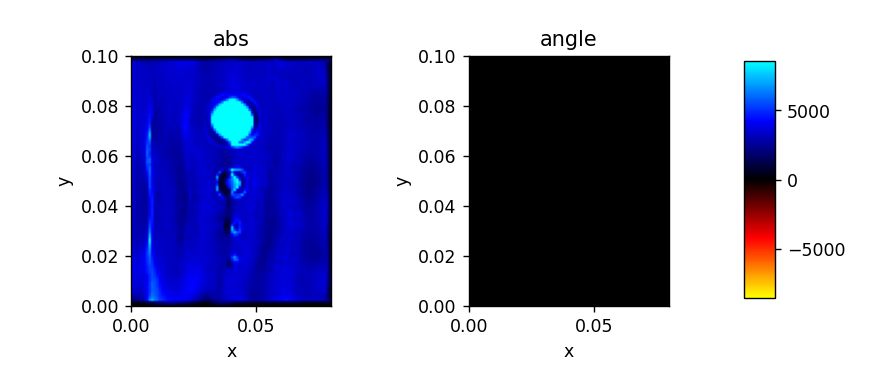

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [6]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, ax_width=2, col='part', polar=True)

In [7]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [17]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=4,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (output): Linear(in_features=387, out_features=2, bias=True)
  )
)

In [18]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_step_iters=1000,
    pde_init_weight=1e-19,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000258 s



In [19]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0005s (1.02%)
Model time/iter: 0.0007s (1.35%)
Loss time/iter:  0.0473s (97.64%)
Total time/iter: 0.0484s
Total time: 4.8408s
1k iters time: 0.81m
10k iters time: 8.07m
100k iters time: 1.34h


<IPython.core.display.Javascript object>


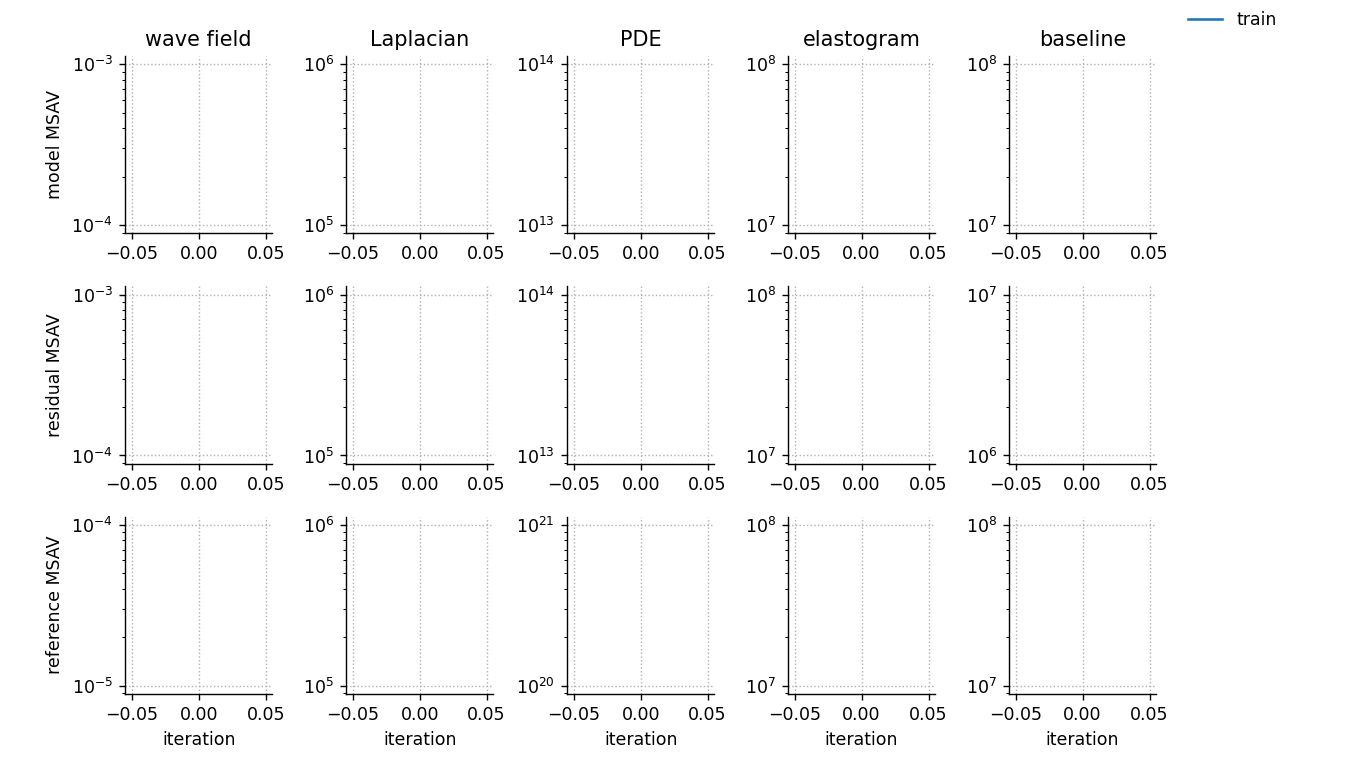

<IPython.core.display.Javascript object>


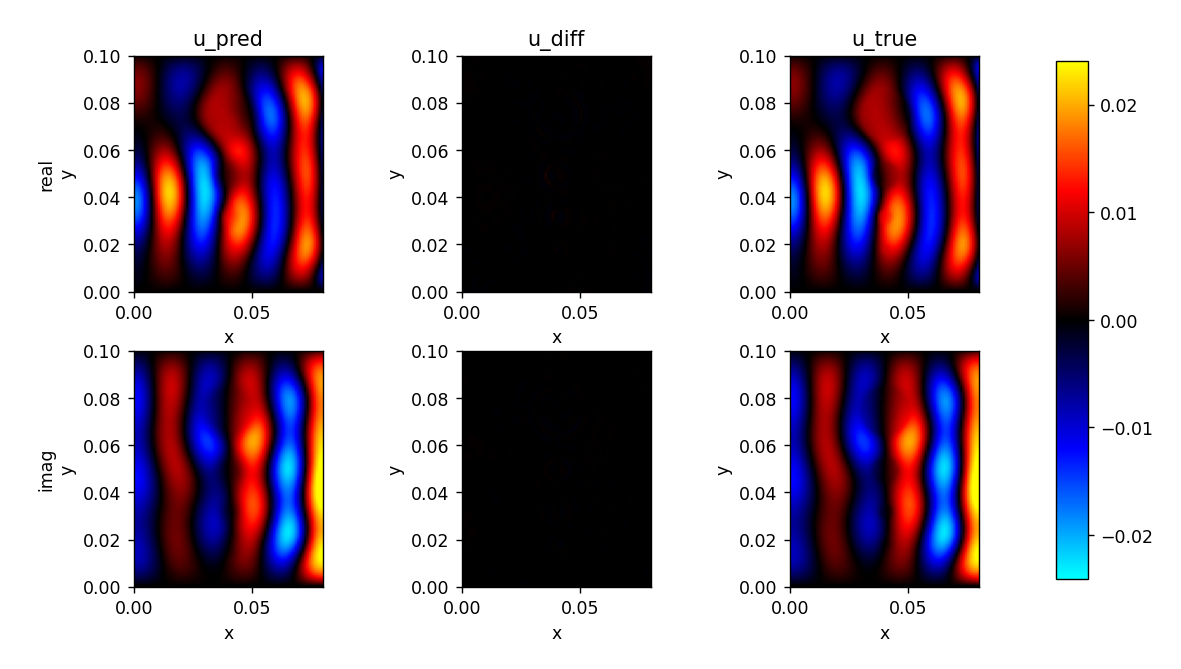

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


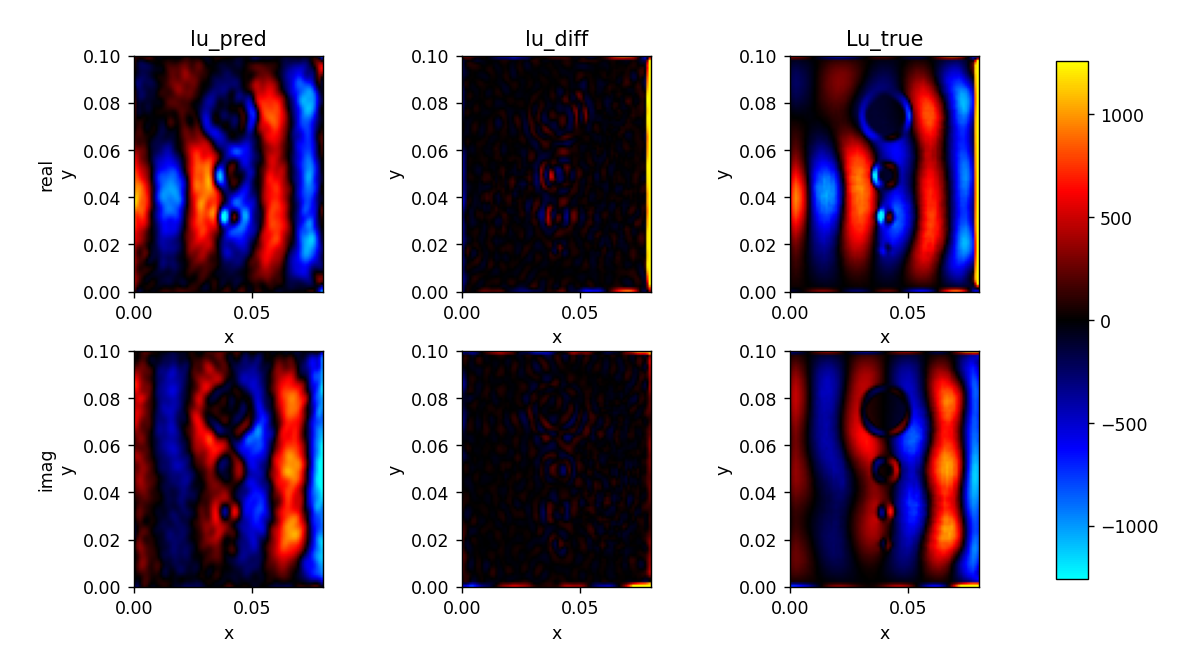

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


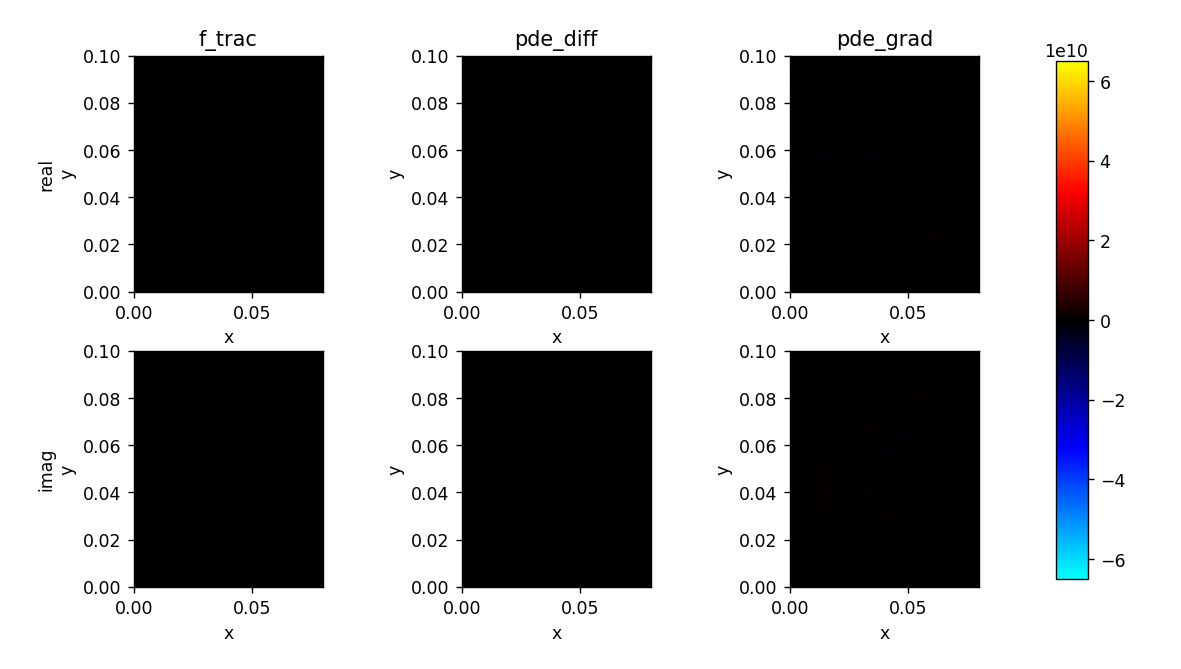

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


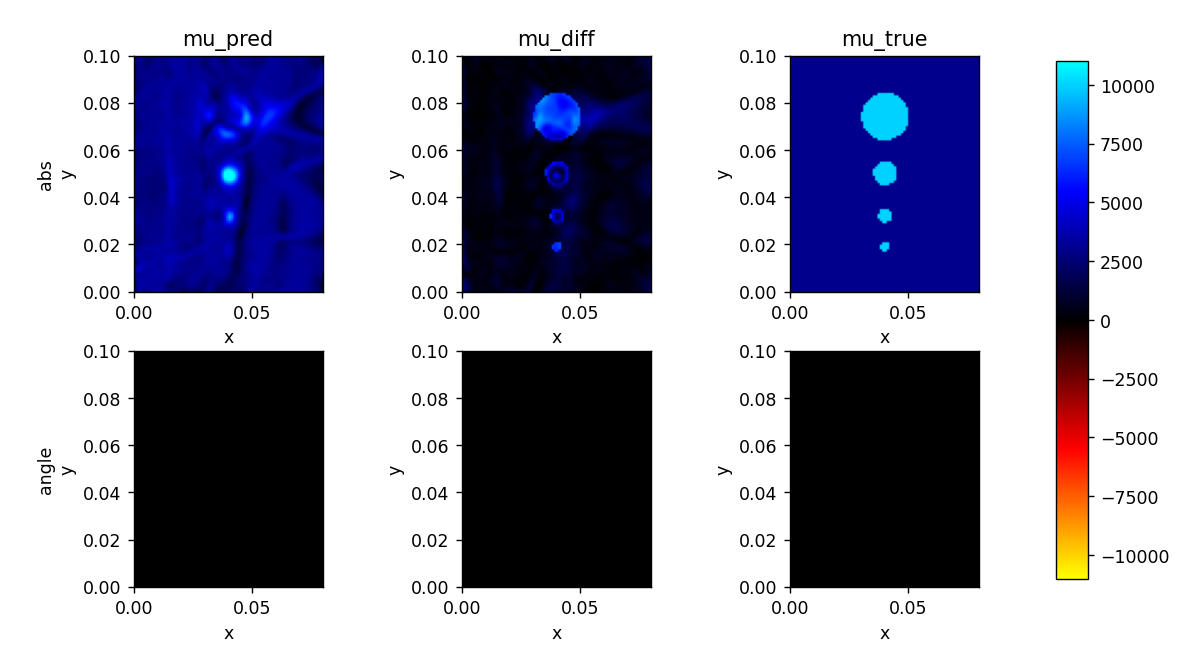

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


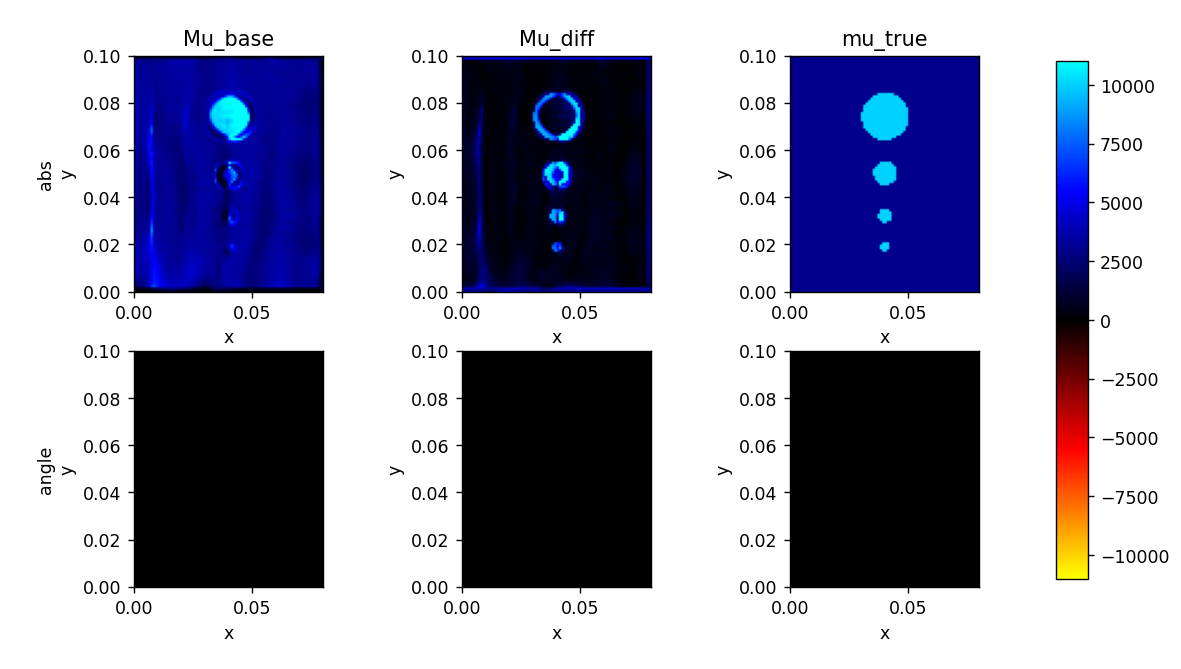

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [20]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [7.05e-04, 0.00e+00, 0.00e+00]    [6.63e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


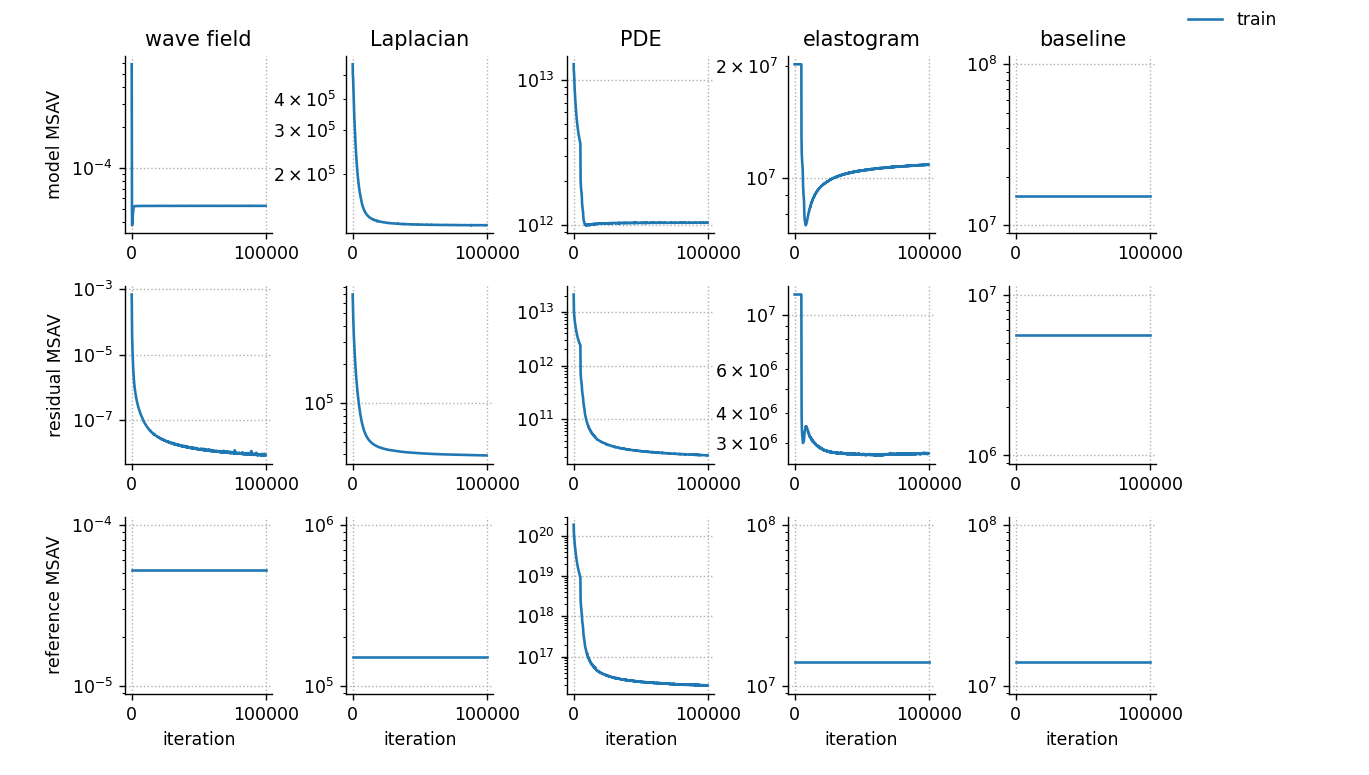

Time spent testing: 13.5757 (3.92%)
10        [6.04e-04, 0.00e+00, 0.00e+00]    [5.90e-04, 0.00e+00, 0.00e+00]    []  
20        [5.20e-04, 0.00e+00, 0.00e+00]    [5.24e-04, 0.00e+00, 0.00e+00]    []  
30        [4.59e-04, 0.00e+00, 0.00e+00]    [4.65e-04, 0.00e+00, 0.00e+00]    []  
40        [4.24e-04, 0.00e+00, 0.00e+00]    [4.13e-04, 0.00e+00, 0.00e+00]    []  
50        [3.98e-04, 0.00e+00, 0.00e+00]    [3.66e-04, 0.00e+00, 0.00e+00]    []  
60        [3.27e-04, 0.00e+00, 0.00e+00]    [3.23e-04, 0.00e+00, 0.00e+00]    []  
70        [2.98e-04, 0.00e+00, 0.00e+00]    [2.86e-04, 0.00e+00, 0.00e+00]    []  
80        [2.47e-04, 0.00e+00, 0.00e+00]    [2.53e-04, 0.00e+00, 0.00e+00]    []  
90        [2.39e-04, 0.00e+00, 0.00e+00]    [2.23e-04, 0.00e+00, 0.00e+00]    []  
100       [1.96e-04, 0.00e+00, 0.00e+00]    [1.98e-04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 13.5176 (7.37%)
110       [1.91e-04, 0.00e+00, 0.00e+00]    [1.75e-04, 0.00e+00, 0.00e+00]    []  
120       [1.66

960       [5.38e-06, 0.00e+00, 0.00e+00]    [5.20e-06, 0.00e+00, 0.00e+00]    []  
970       [5.27e-06, 0.00e+00, 0.00e+00]    [5.08e-06, 0.00e+00, 0.00e+00]    []  
980       [4.88e-06, 0.00e+00, 0.00e+00]    [4.97e-06, 0.00e+00, 0.00e+00]    []  
990       [4.87e-06, 0.00e+00, 0.00e+00]    [4.87e-06, 0.00e+00, 0.00e+00]    []  
1000      [4.97e-06, 0.00e+00, 0.00e+00]    [4.78e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.4528 (26.40%)
1010      [4.91e-06, 0.00e+00, 0.00e+00]    [4.69e-06, 0.00e+00, 0.00e+00]    []  
1020      [4.58e-06, 0.00e+00, 0.00e+00]    [4.60e-06, 0.00e+00, 0.00e+00]    []  
1030      [4.43e-06, 0.00e+00, 0.00e+00]    [4.50e-06, 0.00e+00, 0.00e+00]    []  
1040      [4.33e-06, 0.00e+00, 0.00e+00]    [4.40e-06, 0.00e+00, 0.00e+00]    []  
1050      [4.34e-06, 0.00e+00, 0.00e+00]    [4.31e-06, 0.00e+00, 0.00e+00]    []  
1060      [4.30e-06, 0.00e+00, 0.00e+00]    [4.23e-06, 0.00e+00, 0.00e+00]    []  
1070      [4.09e-06, 0.00e+00, 0.00e+00]    [4.15e

Time spent testing: 13.3990 (36.34%)
1910      [1.27e-06, 0.00e+00, 0.00e+00]    [1.31e-06, 0.00e+00, 0.00e+00]    []  
1920      [1.27e-06, 0.00e+00, 0.00e+00]    [1.30e-06, 0.00e+00, 0.00e+00]    []  
1930      [1.25e-06, 0.00e+00, 0.00e+00]    [1.28e-06, 0.00e+00, 0.00e+00]    []  
1940      [1.26e-06, 0.00e+00, 0.00e+00]    [1.27e-06, 0.00e+00, 0.00e+00]    []  
1950      [1.30e-06, 0.00e+00, 0.00e+00]    [1.26e-06, 0.00e+00, 0.00e+00]    []  
1960      [1.18e-06, 0.00e+00, 0.00e+00]    [1.25e-06, 0.00e+00, 0.00e+00]    []  
1970      [1.23e-06, 0.00e+00, 0.00e+00]    [1.23e-06, 0.00e+00, 0.00e+00]    []  
1980      [1.13e-06, 0.00e+00, 0.00e+00]    [1.22e-06, 0.00e+00, 0.00e+00]    []  
1990      [1.18e-06, 0.00e+00, 0.00e+00]    [1.21e-06, 0.00e+00, 0.00e+00]    []  
2000      [1.16e-06, 0.00e+00, 0.00e+00]    [1.20e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 13.1807 (37.16%)
2010      [1.19e-06, 0.00e+00, 0.00e+00]    [1.19e-06, 0.00e+00, 0.00e+00]    []  
2020      [1.

2860      [6.25e-07, 0.00e+00, 0.00e+00]    [6.42e-07, 0.00e+00, 0.00e+00]    []  
2870      [6.47e-07, 0.00e+00, 0.00e+00]    [6.40e-07, 0.00e+00, 0.00e+00]    []  
2880      [6.24e-07, 0.00e+00, 0.00e+00]    [6.36e-07, 0.00e+00, 0.00e+00]    []  
2890      [5.99e-07, 0.00e+00, 0.00e+00]    [6.33e-07, 0.00e+00, 0.00e+00]    []  
2900      [6.34e-07, 0.00e+00, 0.00e+00]    [6.29e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 13.1913 (42.84%)
2910      [6.04e-07, 0.00e+00, 0.00e+00]    [6.25e-07, 0.00e+00, 0.00e+00]    []  
2920      [5.94e-07, 0.00e+00, 0.00e+00]    [6.23e-07, 0.00e+00, 0.00e+00]    []  
2930      [6.20e-07, 0.00e+00, 0.00e+00]    [6.22e-07, 0.00e+00, 0.00e+00]    []  
2940      [5.93e-07, 0.00e+00, 0.00e+00]    [6.18e-07, 0.00e+00, 0.00e+00]    []  
2950      [5.69e-07, 0.00e+00, 0.00e+00]    [6.15e-07, 0.00e+00, 0.00e+00]    []  
2960      [6.03e-07, 0.00e+00, 0.00e+00]    [6.11e-07, 0.00e+00, 0.00e+00]    []  
2970      [6.25e-07, 0.00e+00, 0.00e+00]    [6.07e

Time spent testing: 13.1403 (46.71%)
3810      [3.95e-07, 0.00e+00, 0.00e+00]    [3.97e-07, 0.00e+00, 0.00e+00]    []  
3820      [3.73e-07, 0.00e+00, 0.00e+00]    [3.97e-07, 0.00e+00, 0.00e+00]    []  
3830      [3.94e-07, 0.00e+00, 0.00e+00]    [3.98e-07, 0.00e+00, 0.00e+00]    []  
3840      [3.75e-07, 0.00e+00, 0.00e+00]    [3.95e-07, 0.00e+00, 0.00e+00]    []  
3850      [3.87e-07, 0.00e+00, 0.00e+00]    [3.92e-07, 0.00e+00, 0.00e+00]    []  
3860      [4.08e-07, 0.00e+00, 0.00e+00]    [3.91e-07, 0.00e+00, 0.00e+00]    []  
3870      [3.72e-07, 0.00e+00, 0.00e+00]    [3.89e-07, 0.00e+00, 0.00e+00]    []  
3880      [3.74e-07, 0.00e+00, 0.00e+00]    [3.87e-07, 0.00e+00, 0.00e+00]    []  
3890      [3.75e-07, 0.00e+00, 0.00e+00]    [3.85e-07, 0.00e+00, 0.00e+00]    []  
3900      [4.21e-07, 0.00e+00, 0.00e+00]    [3.83e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.9758 (47.08%)
3910      [3.82e-07, 0.00e+00, 0.00e+00]    [3.84e-07, 0.00e+00, 0.00e+00]    []  
3920      [3.

4760      [2.73e-07, 0.00e+00, 0.00e+00]    [2.75e-07, 0.00e+00, 0.00e+00]    []  
4770      [2.62e-07, 0.00e+00, 0.00e+00]    [2.76e-07, 0.00e+00, 0.00e+00]    []  
4780      [2.65e-07, 0.00e+00, 0.00e+00]    [2.73e-07, 0.00e+00, 0.00e+00]    []  
4790      [2.64e-07, 0.00e+00, 0.00e+00]    [2.71e-07, 0.00e+00, 0.00e+00]    []  
4800      [2.64e-07, 0.00e+00, 0.00e+00]    [2.71e-07, 0.00e+00, 0.00e+00]    []  
Time spent testing: 13.2531 (49.87%)
4810      [2.64e-07, 0.00e+00, 0.00e+00]    [2.70e-07, 0.00e+00, 0.00e+00]    []  
4820      [2.62e-07, 0.00e+00, 0.00e+00]    [2.69e-07, 0.00e+00, 0.00e+00]    []  
4830      [2.60e-07, 0.00e+00, 0.00e+00]    [2.67e-07, 0.00e+00, 0.00e+00]    []  
4840      [2.56e-07, 0.00e+00, 0.00e+00]    [2.67e-07, 0.00e+00, 0.00e+00]    []  
4850      [2.54e-07, 0.00e+00, 0.00e+00]    [2.66e-07, 0.00e+00, 0.00e+00]    []  
4860      [2.66e-07, 0.00e+00, 0.00e+00]    [2.65e-07, 0.00e+00, 0.00e+00]    []  
4870      [2.57e-07, 0.00e+00, 0.00e+00]    [2.64e

Time spent testing: 13.0026 (51.90%)
5710      [2.03e-07, 0.00e+00, 5.23e-08]    [2.02e-07, 0.00e+00, 4.99e-08]    []  
5720      [1.91e-07, 0.00e+00, 5.00e-08]    [2.01e-07, 0.00e+00, 4.96e-08]    []  
5730      [2.01e-07, 0.00e+00, 5.16e-08]    [2.01e-07, 0.00e+00, 4.94e-08]    []  
5740      [2.01e-07, 0.00e+00, 5.24e-08]    [2.00e-07, 0.00e+00, 4.91e-08]    []  
5750      [1.95e-07, 0.00e+00, 4.75e-08]    [2.00e-07, 0.00e+00, 4.89e-08]    []  
5760      [1.98e-07, 0.00e+00, 4.99e-08]    [2.00e-07, 0.00e+00, 4.87e-08]    []  
5770      [2.03e-07, 0.00e+00, 4.84e-08]    [2.01e-07, 0.00e+00, 4.85e-08]    []  
5780      [2.04e-07, 0.00e+00, 4.98e-08]    [2.01e-07, 0.00e+00, 4.82e-08]    []  
5790      [1.91e-07, 0.00e+00, 4.50e-08]    [2.00e-07, 0.00e+00, 4.82e-08]    []  
5800      [1.91e-07, 0.00e+00, 4.87e-08]    [1.99e-07, 0.00e+00, 4.79e-08]    []  
Time spent testing: 13.0379 (52.09%)
5810      [1.81e-07, 0.00e+00, 4.66e-08]    [1.98e-07, 0.00e+00, 4.77e-08]    []  
5820      [1.

6660      [1.55e-07, 0.00e+00, 2.82e-07]    [1.56e-07, 0.00e+00, 2.79e-07]    []  
6670      [1.51e-07, 0.00e+00, 2.84e-07]    [1.56e-07, 0.00e+00, 2.78e-07]    []  
6680      [1.53e-07, 0.00e+00, 2.87e-07]    [1.55e-07, 0.00e+00, 2.78e-07]    []  
6690      [1.51e-07, 0.00e+00, 2.83e-07]    [1.55e-07, 0.00e+00, 2.77e-07]    []  
6700      [1.51e-07, 0.00e+00, 2.86e-07]    [1.56e-07, 0.00e+00, 2.76e-07]    []  
Time spent testing: 13.0520 (53.74%)
6710      [1.51e-07, 0.00e+00, 2.95e-07]    [1.55e-07, 0.00e+00, 2.74e-07]    []  
6720      [1.54e-07, 0.00e+00, 2.90e-07]    [1.55e-07, 0.00e+00, 2.73e-07]    []  
6730      [1.47e-07, 0.00e+00, 2.71e-07]    [1.54e-07, 0.00e+00, 2.73e-07]    []  
6740      [1.51e-07, 0.00e+00, 2.70e-07]    [1.55e-07, 0.00e+00, 2.72e-07]    []  
6750      [1.48e-07, 0.00e+00, 2.70e-07]    [1.53e-07, 0.00e+00, 2.72e-07]    []  
6760      [1.54e-07, 0.00e+00, 2.84e-07]    [1.53e-07, 0.00e+00, 2.71e-07]    []  
6770      [1.43e-07, 0.00e+00, 2.59e-07]    [1.54e

Time spent testing: 13.1469 (55.02%)
7610      [1.27e-07, 0.00e+00, 1.77e-06]    [1.25e-07, 0.00e+00, 1.80e-06]    []  
7620      [1.26e-07, 0.00e+00, 1.72e-06]    [1.25e-07, 0.00e+00, 1.80e-06]    []  
7630      [1.18e-07, 0.00e+00, 1.69e-06]    [1.26e-07, 0.00e+00, 1.80e-06]    []  
7640      [1.19e-07, 0.00e+00, 1.85e-06]    [1.23e-07, 0.00e+00, 1.79e-06]    []  
7650      [1.20e-07, 0.00e+00, 1.74e-06]    [1.25e-07, 0.00e+00, 1.78e-06]    []  
7660      [1.16e-07, 0.00e+00, 1.76e-06]    [1.25e-07, 0.00e+00, 1.78e-06]    []  
7670      [1.22e-07, 0.00e+00, 1.73e-06]    [1.24e-07, 0.00e+00, 1.78e-06]    []  
7680      [1.20e-07, 0.00e+00, 1.76e-06]    [1.23e-07, 0.00e+00, 1.77e-06]    []  
7690      [1.17e-07, 0.00e+00, 1.62e-06]    [1.22e-07, 0.00e+00, 1.76e-06]    []  
7700      [1.25e-07, 0.00e+00, 1.75e-06]    [1.23e-07, 0.00e+00, 1.76e-06]    []  
Time spent testing: 12.9380 (55.15%)
7710      [1.17e-07, 0.00e+00, 1.61e-06]    [1.22e-07, 0.00e+00, 1.75e-06]    []  
7720      [1.

8560      [9.93e-08, 0.00e+00, 1.17e-05]    [1.03e-07, 0.00e+00, 1.22e-05]    []  
8570      [9.34e-08, 0.00e+00, 1.25e-05]    [1.03e-07, 0.00e+00, 1.20e-05]    []  
8580      [9.69e-08, 0.00e+00, 1.20e-05]    [1.03e-07, 0.00e+00, 1.20e-05]    []  
8590      [9.81e-08, 0.00e+00, 1.21e-05]    [1.03e-07, 0.00e+00, 1.20e-05]    []  
8600      [9.85e-08, 0.00e+00, 1.17e-05]    [1.02e-07, 0.00e+00, 1.20e-05]    []  
Time spent testing: 13.2965 (56.23%)
8610      [1.07e-07, 0.00e+00, 1.22e-05]    [1.02e-07, 0.00e+00, 1.19e-05]    []  
8620      [9.84e-08, 0.00e+00, 1.18e-05]    [1.01e-07, 0.00e+00, 1.18e-05]    []  
8630      [9.98e-08, 0.00e+00, 1.18e-05]    [1.01e-07, 0.00e+00, 1.17e-05]    []  
8640      [1.00e-07, 0.00e+00, 1.18e-05]    [1.01e-07, 0.00e+00, 1.18e-05]    []  
8650      [9.67e-08, 0.00e+00, 1.22e-05]    [1.01e-07, 0.00e+00, 1.19e-05]    []  
8660      [9.66e-08, 0.00e+00, 1.23e-05]    [1.00e-07, 0.00e+00, 1.18e-05]    []  
8670      [9.48e-08, 0.00e+00, 1.09e-05]    [1.00e

Time spent testing: 13.3317 (57.14%)
9510      [8.67e-08, 0.00e+00, 9.41e-05]    [8.66e-08, 0.00e+00, 9.14e-05]    []  
9520      [7.85e-08, 0.00e+00, 9.56e-05]    [8.63e-08, 0.00e+00, 9.12e-05]    []  
9530      [8.01e-08, 0.00e+00, 9.76e-05]    [8.49e-08, 0.00e+00, 9.11e-05]    []  
9540      [8.07e-08, 0.00e+00, 9.63e-05]    [8.67e-08, 0.00e+00, 9.13e-05]    []  
9550      [8.62e-08, 0.00e+00, 9.24e-05]    [8.46e-08, 0.00e+00, 9.15e-05]    []  
9560      [8.57e-08, 0.00e+00, 9.90e-05]    [8.66e-08, 0.00e+00, 9.13e-05]    []  
9570      [7.95e-08, 0.00e+00, 9.77e-05]    [8.48e-08, 0.00e+00, 9.04e-05]    []  
9580      [8.58e-08, 0.00e+00, 1.01e-04]    [8.50e-08, 0.00e+00, 9.00e-05]    []  
9590      [8.25e-08, 0.00e+00, 9.46e-05]    [8.57e-08, 0.00e+00, 9.02e-05]    []  
9600      [8.03e-08, 0.00e+00, 9.24e-05]    [8.48e-08, 0.00e+00, 9.05e-05]    []  
Time spent testing: 13.2497 (57.24%)
9610      [8.42e-08, 0.00e+00, 8.94e-05]    [8.48e-08, 0.00e+00, 8.97e-05]    []  
9620      [8.

10460     [6.91e-08, 0.00e+00, 7.24e-04]    [7.37e-08, 0.00e+00, 7.66e-04]    []  
10470     [7.04e-08, 0.00e+00, 8.52e-04]    [7.42e-08, 0.00e+00, 7.62e-04]    []  
10480     [7.20e-08, 0.00e+00, 7.76e-04]    [7.53e-08, 0.00e+00, 7.67e-04]    []  
10490     [7.25e-08, 0.00e+00, 7.60e-04]    [7.44e-08, 0.00e+00, 7.61e-04]    []  
10500     [7.19e-08, 0.00e+00, 7.93e-04]    [7.36e-08, 0.00e+00, 7.51e-04]    []  
Time spent testing: 13.5550 (57.97%)
10510     [7.28e-08, 0.00e+00, 8.18e-04]    [7.32e-08, 0.00e+00, 7.53e-04]    []  
10520     [7.18e-08, 0.00e+00, 7.24e-04]    [7.34e-08, 0.00e+00, 7.55e-04]    []  
10530     [7.12e-08, 0.00e+00, 7.50e-04]    [7.27e-08, 0.00e+00, 7.54e-04]    []  
10540     [7.00e-08, 0.00e+00, 7.53e-04]    [7.29e-08, 0.00e+00, 7.56e-04]    []  
10550     [7.29e-08, 0.00e+00, 7.98e-04]    [7.24e-08, 0.00e+00, 7.48e-04]    []  
10560     [7.14e-08, 0.00e+00, 7.78e-04]    [7.19e-08, 0.00e+00, 7.43e-04]    []  
10570     [7.15e-08, 0.00e+00, 7.59e-04]    [7.25e

Time spent testing: 13.2866 (58.65%)
11410     [6.20e-08, 0.00e+00, 7.02e-03]    [6.42e-08, 0.00e+00, 6.71e-03]    []  
11420     [6.17e-08, 0.00e+00, 6.74e-03]    [6.47e-08, 0.00e+00, 6.65e-03]    []  
11430     [6.02e-08, 0.00e+00, 6.45e-03]    [6.48e-08, 0.00e+00, 6.67e-03]    []  
11440     [6.26e-08, 0.00e+00, 7.09e-03]    [6.43e-08, 0.00e+00, 6.67e-03]    []  
11450     [6.09e-08, 0.00e+00, 6.96e-03]    [6.40e-08, 0.00e+00, 6.68e-03]    []  
11460     [6.02e-08, 0.00e+00, 6.60e-03]    [6.31e-08, 0.00e+00, 6.61e-03]    []  
11470     [6.07e-08, 0.00e+00, 7.30e-03]    [6.44e-08, 0.00e+00, 6.62e-03]    []  
11480     [5.86e-08, 0.00e+00, 6.35e-03]    [6.41e-08, 0.00e+00, 6.64e-03]    []  
11490     [6.10e-08, 0.00e+00, 6.62e-03]    [6.39e-08, 0.00e+00, 6.63e-03]    []  
11500     [6.52e-08, 0.00e+00, 6.69e-03]    [6.45e-08, 0.00e+00, 6.55e-03]    []  
Time spent testing: 13.3243 (58.72%)
11510     [5.80e-08, 0.00e+00, 6.75e-03]    [6.34e-08, 0.00e+00, 6.58e-03]    []  
11520     [6.

12360     [5.45e-08, 0.00e+00, 6.26e-02]    [5.75e-08, 0.00e+00, 6.09e-02]    []  
12370     [5.48e-08, 0.00e+00, 6.47e-02]    [5.73e-08, 0.00e+00, 6.09e-02]    []  
12380     [5.52e-08, 0.00e+00, 5.70e-02]    [5.83e-08, 0.00e+00, 6.09e-02]    []  
12390     [5.38e-08, 0.00e+00, 5.76e-02]    [5.72e-08, 0.00e+00, 6.07e-02]    []  
12400     [5.84e-08, 0.00e+00, 6.30e-02]    [5.79e-08, 0.00e+00, 5.99e-02]    []  
Time spent testing: 13.5512 (59.29%)
12410     [5.72e-08, 0.00e+00, 6.23e-02]    [5.78e-08, 0.00e+00, 6.02e-02]    []  
12420     [5.71e-08, 0.00e+00, 6.20e-02]    [5.75e-08, 0.00e+00, 6.13e-02]    []  
12430     [5.68e-08, 0.00e+00, 6.26e-02]    [5.73e-08, 0.00e+00, 6.02e-02]    []  
12440     [5.46e-08, 0.00e+00, 5.69e-02]    [5.67e-08, 0.00e+00, 5.99e-02]    []  
12450     [5.54e-08, 0.00e+00, 6.29e-02]    [5.68e-08, 0.00e+00, 5.96e-02]    []  
12460     [5.35e-08, 0.00e+00, 5.87e-02]    [5.63e-08, 0.00e+00, 5.99e-02]    []  
12470     [5.52e-08, 0.00e+00, 5.77e-02]    [5.65e

Time spent testing: 13.4214 (59.75%)
13310     [4.93e-08, 0.00e+00, 5.33e-01]    [5.13e-08, 0.00e+00, 5.61e-01]    []  
13320     [5.04e-08, 0.00e+00, 5.68e-01]    [5.12e-08, 0.00e+00, 5.41e-01]    []  
13330     [5.12e-08, 0.00e+00, 5.25e-01]    [5.17e-08, 0.00e+00, 5.41e-01]    []  
13340     [4.87e-08, 0.00e+00, 5.34e-01]    [5.06e-08, 0.00e+00, 5.43e-01]    []  
13350     [4.87e-08, 0.00e+00, 5.68e-01]    [5.06e-08, 0.00e+00, 5.40e-01]    []  
13360     [4.77e-08, 0.00e+00, 5.11e-01]    [5.11e-08, 0.00e+00, 5.31e-01]    []  
13370     [4.92e-08, 0.00e+00, 5.42e-01]    [5.10e-08, 0.00e+00, 5.34e-01]    []  
13380     [4.89e-08, 0.00e+00, 5.35e-01]    [5.16e-08, 0.00e+00, 5.33e-01]    []  
13390     [4.94e-08, 0.00e+00, 5.54e-01]    [5.10e-08, 0.00e+00, 5.41e-01]    []  
13400     [4.77e-08, 0.00e+00, 5.36e-01]    [5.14e-08, 0.00e+00, 5.44e-01]    []  
Time spent testing: 13.3426 (59.81%)
13410     [4.97e-08, 0.00e+00, 5.71e-01]    [5.06e-08, 0.00e+00, 5.43e-01]    []  
13420     [4.

14260     [4.58e-08, 0.00e+00, 5.16e+00]    [4.70e-08, 0.00e+00, 5.08e+00]    []  
14270     [4.57e-08, 0.00e+00, 5.19e+00]    [4.68e-08, 0.00e+00, 5.13e+00]    []  
14280     [4.41e-08, 0.00e+00, 5.34e+00]    [4.77e-08, 0.00e+00, 5.05e+00]    []  
14290     [4.79e-08, 0.00e+00, 5.25e+00]    [4.64e-08, 0.00e+00, 5.04e+00]    []  
14300     [4.44e-08, 0.00e+00, 5.12e+00]    [4.67e-08, 0.00e+00, 5.03e+00]    []  
Time spent testing: 13.5601 (60.26%)
14310     [4.58e-08, 0.00e+00, 4.79e+00]    [4.70e-08, 0.00e+00, 5.05e+00]    []  
14320     [4.42e-08, 0.00e+00, 5.24e+00]    [4.71e-08, 0.00e+00, 5.06e+00]    []  
14330     [4.47e-08, 0.00e+00, 5.01e+00]    [4.64e-08, 0.00e+00, 5.01e+00]    []  
14340     [4.42e-08, 0.00e+00, 4.74e+00]    [4.66e-08, 0.00e+00, 5.01e+00]    []  
14350     [4.43e-08, 0.00e+00, 5.12e+00]    [4.64e-08, 0.00e+00, 5.00e+00]    []  
14360     [4.26e-08, 0.00e+00, 5.47e+00]    [4.58e-08, 0.00e+00, 4.98e+00]    []  
14370     [4.58e-08, 0.00e+00, 5.14e+00]    [4.67e

Time spent testing: 13.5085 (60.63%)
15210     [4.24e-08, 0.00e+00, 5.00e+01]    [4.26e-08, 0.00e+00, 4.80e+01]    []  
15220     [4.21e-08, 0.00e+00, 4.72e+01]    [4.22e-08, 0.00e+00, 4.68e+01]    []  
15230     [4.08e-08, 0.00e+00, 4.61e+01]    [4.24e-08, 0.00e+00, 4.61e+01]    []  
15240     [4.26e-08, 0.00e+00, 4.78e+01]    [4.27e-08, 0.00e+00, 4.69e+01]    []  
15250     [3.98e-08, 0.00e+00, 4.67e+01]    [4.30e-08, 0.00e+00, 4.72e+01]    []  
15260     [4.19e-08, 0.00e+00, 4.65e+01]    [4.26e-08, 0.00e+00, 4.65e+01]    []  
15270     [4.30e-08, 0.00e+00, 4.77e+01]    [4.27e-08, 0.00e+00, 4.59e+01]    []  
15280     [3.90e-08, 0.00e+00, 4.96e+01]    [4.25e-08, 0.00e+00, 4.72e+01]    []  
15290     [4.13e-08, 0.00e+00, 4.68e+01]    [4.23e-08, 0.00e+00, 4.68e+01]    []  
15300     [4.22e-08, 0.00e+00, 4.83e+01]    [4.22e-08, 0.00e+00, 4.66e+01]    []  
Time spent testing: 13.4979 (60.67%)
15310     [4.20e-08, 0.00e+00, 4.96e+01]    [4.28e-08, 0.00e+00, 4.71e+01]    []  
15320     [4.

16160     [3.73e-08, 0.00e+00, 4.67e+02]    [3.99e-08, 0.00e+00, 4.54e+02]    []  
16170     [3.59e-08, 0.00e+00, 4.53e+02]    [3.99e-08, 0.00e+00, 4.39e+02]    []  
16180     [3.97e-08, 0.00e+00, 4.12e+02]    [4.04e-08, 0.00e+00, 4.49e+02]    []  
16190     [3.61e-08, 0.00e+00, 4.65e+02]    [4.02e-08, 0.00e+00, 4.48e+02]    []  
16200     [3.73e-08, 0.00e+00, 4.41e+02]    [3.96e-08, 0.00e+00, 4.47e+02]    []  
Time spent testing: 13.7425 (61.01%)
16210     [3.67e-08, 0.00e+00, 4.48e+02]    [3.91e-08, 0.00e+00, 4.46e+02]    []  
16220     [3.54e-08, 0.00e+00, 4.50e+02]    [3.93e-08, 0.00e+00, 4.38e+02]    []  
16230     [3.96e-08, 0.00e+00, 4.49e+02]    [3.93e-08, 0.00e+00, 4.40e+02]    []  
16240     [4.02e-08, 0.00e+00, 4.54e+02]    [3.89e-08, 0.00e+00, 4.42e+02]    []  
16250     [3.59e-08, 0.00e+00, 4.21e+02]    [4.01e-08, 0.00e+00, 4.39e+02]    []  
16260     [3.77e-08, 0.00e+00, 4.42e+02]    [4.00e-08, 0.00e+00, 4.42e+02]    []  
16270     [4.02e-08, 0.00e+00, 4.85e+02]    [3.92e

Time spent testing: 13.5192 (61.34%)
17110     [3.57e-08, 0.00e+00, 4.41e+02]    [3.64e-08, 0.00e+00, 4.07e+02]    []  
17120     [3.39e-08, 0.00e+00, 4.26e+02]    [3.64e-08, 0.00e+00, 4.11e+02]    []  
17130     [3.53e-08, 0.00e+00, 4.04e+02]    [3.67e-08, 0.00e+00, 4.09e+02]    []  
17140     [3.43e-08, 0.00e+00, 4.26e+02]    [3.74e-08, 0.00e+00, 4.07e+02]    []  
17150     [3.88e-08, 0.00e+00, 4.16e+02]    [3.65e-08, 0.00e+00, 4.03e+02]    []  
17160     [3.53e-08, 0.00e+00, 4.79e+02]    [3.68e-08, 0.00e+00, 4.02e+02]    []  
17170     [3.53e-08, 0.00e+00, 4.16e+02]    [3.70e-08, 0.00e+00, 4.10e+02]    []  
17180     [3.56e-08, 0.00e+00, 4.38e+02]    [3.71e-08, 0.00e+00, 4.05e+02]    []  
17190     [3.64e-08, 0.00e+00, 4.32e+02]    [3.67e-08, 0.00e+00, 4.04e+02]    []  
17200     [3.71e-08, 0.00e+00, 4.54e+02]    [3.65e-08, 0.00e+00, 4.00e+02]    []  
Time spent testing: 13.6746 (61.38%)
17210     [3.49e-08, 0.00e+00, 4.24e+02]    [3.68e-08, 0.00e+00, 4.05e+02]    []  
17220     [3.

18060     [3.24e-08, 0.00e+00, 4.03e+02]    [3.42e-08, 0.00e+00, 3.91e+02]    []  
18070     [3.36e-08, 0.00e+00, 4.34e+02]    [3.41e-08, 0.00e+00, 3.85e+02]    []  
18080     [3.38e-08, 0.00e+00, 4.16e+02]    [3.40e-08, 0.00e+00, 3.85e+02]    []  
18090     [3.45e-08, 0.00e+00, 4.00e+02]    [3.51e-08, 0.00e+00, 3.85e+02]    []  
18100     [3.24e-08, 0.00e+00, 3.88e+02]    [3.46e-08, 0.00e+00, 3.85e+02]    []  
Time spent testing: 13.5738 (61.65%)
18110     [3.47e-08, 0.00e+00, 4.07e+02]    [3.50e-08, 0.00e+00, 3.81e+02]    []  
18120     [3.23e-08, 0.00e+00, 4.11e+02]    [3.42e-08, 0.00e+00, 3.87e+02]    []  
18130     [3.27e-08, 0.00e+00, 3.95e+02]    [3.44e-08, 0.00e+00, 3.87e+02]    []  
18140     [3.10e-08, 0.00e+00, 3.85e+02]    [3.49e-08, 0.00e+00, 3.83e+02]    []  
18150     [3.18e-08, 0.00e+00, 4.05e+02]    [3.39e-08, 0.00e+00, 3.90e+02]    []  
18160     [3.17e-08, 0.00e+00, 4.03e+02]    [3.44e-08, 0.00e+00, 3.87e+02]    []  
18170     [3.22e-08, 0.00e+00, 4.31e+02]    [3.37e

Time spent testing: 13.2311 (61.92%)
19010     [3.08e-08, 0.00e+00, 3.77e+02]    [3.38e-08, 0.00e+00, 3.70e+02]    []  
19020     [3.15e-08, 0.00e+00, 4.06e+02]    [3.24e-08, 0.00e+00, 3.71e+02]    []  
19030     [3.09e-08, 0.00e+00, 3.99e+02]    [3.29e-08, 0.00e+00, 3.77e+02]    []  
19040     [3.04e-08, 0.00e+00, 4.05e+02]    [3.25e-08, 0.00e+00, 3.76e+02]    []  
19050     [2.92e-08, 0.00e+00, 3.89e+02]    [3.21e-08, 0.00e+00, 3.74e+02]    []  
19060     [3.31e-08, 0.00e+00, 4.17e+02]    [3.27e-08, 0.00e+00, 3.71e+02]    []  
19070     [2.91e-08, 0.00e+00, 4.20e+02]    [3.26e-08, 0.00e+00, 3.73e+02]    []  
19080     [3.11e-08, 0.00e+00, 3.91e+02]    [3.22e-08, 0.00e+00, 3.73e+02]    []  
19090     [3.24e-08, 0.00e+00, 4.05e+02]    [3.25e-08, 0.00e+00, 3.74e+02]    []  
19100     [2.99e-08, 0.00e+00, 3.80e+02]    [3.22e-08, 0.00e+00, 3.77e+02]    []  
Time spent testing: 13.8299 (61.96%)
19110     [2.97e-08, 0.00e+00, 4.11e+02]    [3.26e-08, 0.00e+00, 3.67e+02]    []  
19120     [3.

19960     [2.88e-08, 0.00e+00, 4.06e+02]    [3.02e-08, 0.00e+00, 3.58e+02]    []  
19970     [3.06e-08, 0.00e+00, 3.99e+02]    [3.10e-08, 0.00e+00, 3.63e+02]    []  
19980     [3.11e-08, 0.00e+00, 4.02e+02]    [3.13e-08, 0.00e+00, 3.59e+02]    []  
19990     [2.86e-08, 0.00e+00, 3.62e+02]    [3.13e-08, 0.00e+00, 3.53e+02]    []  
20000     [3.11e-08, 0.00e+00, 4.05e+02]    [3.06e-08, 0.00e+00, 3.55e+02]    []  
Time spent testing: 13.6518 (62.20%)
20010     [2.91e-08, 0.00e+00, 3.83e+02]    [3.04e-08, 0.00e+00, 3.56e+02]    []  
20020     [2.99e-08, 0.00e+00, 3.78e+02]    [3.04e-08, 0.00e+00, 3.54e+02]    []  
20030     [3.06e-08, 0.00e+00, 4.03e+02]    [3.14e-08, 0.00e+00, 3.55e+02]    []  
20040     [3.00e-08, 0.00e+00, 3.73e+02]    [3.10e-08, 0.00e+00, 3.58e+02]    []  
20050     [2.95e-08, 0.00e+00, 4.05e+02]    [3.10e-08, 0.00e+00, 3.56e+02]    []  
20060     [2.94e-08, 0.00e+00, 3.65e+02]    [3.05e-08, 0.00e+00, 3.59e+02]    []  
20070     [2.97e-08, 0.00e+00, 3.88e+02]    [2.99e

Time spent testing: 13.3859 (62.41%)
20910     [2.62e-08, 0.00e+00, 3.99e+02]    [2.91e-08, 0.00e+00, 3.47e+02]    []  
20920     [2.97e-08, 0.00e+00, 3.86e+02]    [2.89e-08, 0.00e+00, 3.46e+02]    []  
20930     [2.68e-08, 0.00e+00, 3.76e+02]    [2.94e-08, 0.00e+00, 3.45e+02]    []  
20940     [2.71e-08, 0.00e+00, 3.75e+02]    [2.89e-08, 0.00e+00, 3.46e+02]    []  
20950     [2.79e-08, 0.00e+00, 3.89e+02]    [2.91e-08, 0.00e+00, 3.45e+02]    []  
20960     [2.53e-08, 0.00e+00, 3.73e+02]    [2.90e-08, 0.00e+00, 3.42e+02]    []  
20970     [2.75e-08, 0.00e+00, 3.61e+02]    [2.87e-08, 0.00e+00, 3.46e+02]    []  
20980     [2.92e-08, 0.00e+00, 3.98e+02]    [2.89e-08, 0.00e+00, 3.46e+02]    []  
20990     [2.66e-08, 0.00e+00, 3.48e+02]    [2.89e-08, 0.00e+00, 3.44e+02]    []  
21000     [2.92e-08, 0.00e+00, 3.49e+02]    [2.84e-08, 0.00e+00, 3.43e+02]    []  
Time spent testing: 13.5562 (62.43%)
21010     [2.57e-08, 0.00e+00, 3.83e+02]    [2.88e-08, 0.00e+00, 3.45e+02]    []  
21020     [2.

21860     [2.64e-08, 0.00e+00, 3.68e+02]    [2.78e-08, 0.00e+00, 3.37e+02]    []  
21870     [2.66e-08, 0.00e+00, 3.79e+02]    [2.82e-08, 0.00e+00, 3.40e+02]    []  
21880     [2.61e-08, 0.00e+00, 3.58e+02]    [2.82e-08, 0.00e+00, 3.43e+02]    []  
21890     [2.50e-08, 0.00e+00, 3.77e+02]    [2.79e-08, 0.00e+00, 3.41e+02]    []  
21900     [2.85e-08, 0.00e+00, 3.98e+02]    [2.82e-08, 0.00e+00, 3.38e+02]    []  
Time spent testing: 13.9901 (62.64%)
21910     [2.64e-08, 0.00e+00, 3.56e+02]    [2.70e-08, 0.00e+00, 3.35e+02]    []  
21920     [2.64e-08, 0.00e+00, 3.74e+02]    [2.78e-08, 0.00e+00, 3.36e+02]    []  
21930     [2.79e-08, 0.00e+00, 3.77e+02]    [2.82e-08, 0.00e+00, 3.39e+02]    []  
21940     [2.67e-08, 0.00e+00, 3.56e+02]    [2.83e-08, 0.00e+00, 3.40e+02]    []  
21950     [2.73e-08, 0.00e+00, 3.49e+02]    [2.86e-08, 0.00e+00, 3.38e+02]    []  
21960     [2.78e-08, 0.00e+00, 3.56e+02]    [2.76e-08, 0.00e+00, 3.39e+02]    []  
21970     [2.58e-08, 0.00e+00, 3.70e+02]    [2.77e

Time spent testing: 13.2778 (62.83%)
22810     [2.51e-08, 0.00e+00, 3.62e+02]    [2.69e-08, 0.00e+00, 3.25e+02]    []  
22820     [2.38e-08, 0.00e+00, 3.50e+02]    [2.63e-08, 0.00e+00, 3.27e+02]    []  
22830     [2.46e-08, 0.00e+00, 3.57e+02]    [2.68e-08, 0.00e+00, 3.27e+02]    []  
22840     [2.50e-08, 0.00e+00, 3.68e+02]    [2.61e-08, 0.00e+00, 3.30e+02]    []  
22850     [2.43e-08, 0.00e+00, 3.54e+02]    [2.59e-08, 0.00e+00, 3.25e+02]    []  
22860     [2.41e-08, 0.00e+00, 3.47e+02]    [2.60e-08, 0.00e+00, 3.24e+02]    []  
22870     [2.44e-08, 0.00e+00, 3.45e+02]    [2.58e-08, 0.00e+00, 3.23e+02]    []  
22880     [2.72e-08, 0.00e+00, 3.45e+02]    [2.62e-08, 0.00e+00, 3.22e+02]    []  
22890     [2.56e-08, 0.00e+00, 3.41e+02]    [2.65e-08, 0.00e+00, 3.24e+02]    []  
22900     [2.46e-08, 0.00e+00, 3.40e+02]    [2.59e-08, 0.00e+00, 3.24e+02]    []  
Time spent testing: 13.4902 (62.86%)
22910     [2.55e-08, 0.00e+00, 3.56e+02]    [2.64e-08, 0.00e+00, 3.25e+02]    []  
22920     [2.

23760     [2.30e-08, 0.00e+00, 3.48e+02]    [2.54e-08, 0.00e+00, 3.23e+02]    []  
23770     [2.28e-08, 0.00e+00, 3.30e+02]    [2.52e-08, 0.00e+00, 3.22e+02]    []  
23780     [2.47e-08, 0.00e+00, 3.51e+02]    [2.57e-08, 0.00e+00, 3.22e+02]    []  
23790     [2.45e-08, 0.00e+00, 3.32e+02]    [2.50e-08, 0.00e+00, 3.26e+02]    []  
23800     [2.44e-08, 0.00e+00, 3.47e+02]    [2.55e-08, 0.00e+00, 3.27e+02]    []  
Time spent testing: 13.2860 (63.03%)
23810     [2.60e-08, 0.00e+00, 3.32e+02]    [2.55e-08, 0.00e+00, 3.23e+02]    []  
23820     [2.15e-08, 0.00e+00, 3.48e+02]    [2.50e-08, 0.00e+00, 3.21e+02]    []  
23830     [2.38e-08, 0.00e+00, 3.61e+02]    [2.50e-08, 0.00e+00, 3.18e+02]    []  
23840     [2.26e-08, 0.00e+00, 3.55e+02]    [2.53e-08, 0.00e+00, 3.21e+02]    []  
23850     [2.18e-08, 0.00e+00, 3.52e+02]    [2.52e-08, 0.00e+00, 3.19e+02]    []  
23860     [2.44e-08, 0.00e+00, 3.36e+02]    [2.58e-08, 0.00e+00, 3.22e+02]    []  
23870     [2.52e-08, 0.00e+00, 3.47e+02]    [2.55e

Time spent testing: 13.1652 (63.20%)
24710     [2.56e-08, 0.00e+00, 3.29e+02]    [2.45e-08, 0.00e+00, 3.11e+02]    []  
24720     [2.30e-08, 0.00e+00, 3.28e+02]    [2.47e-08, 0.00e+00, 3.13e+02]    []  
24730     [2.34e-08, 0.00e+00, 3.55e+02]    [2.46e-08, 0.00e+00, 3.10e+02]    []  
24740     [2.53e-08, 0.00e+00, 3.41e+02]    [2.43e-08, 0.00e+00, 3.11e+02]    []  
24750     [2.35e-08, 0.00e+00, 3.59e+02]    [2.38e-08, 0.00e+00, 3.14e+02]    []  
24760     [2.28e-08, 0.00e+00, 3.40e+02]    [2.48e-08, 0.00e+00, 3.16e+02]    []  
24770     [2.43e-08, 0.00e+00, 3.47e+02]    [2.39e-08, 0.00e+00, 3.11e+02]    []  
24780     [2.28e-08, 0.00e+00, 3.42e+02]    [2.39e-08, 0.00e+00, 3.08e+02]    []  
24790     [2.39e-08, 0.00e+00, 3.32e+02]    [2.43e-08, 0.00e+00, 3.09e+02]    []  
24800     [2.30e-08, 0.00e+00, 3.28e+02]    [2.42e-08, 0.00e+00, 3.12e+02]    []  
Time spent testing: 13.7594 (63.21%)
24810     [2.30e-08, 0.00e+00, 3.23e+02]    [2.43e-08, 0.00e+00, 3.10e+02]    []  
24820     [2.

25660     [2.13e-08, 0.00e+00, 3.23e+02]    [2.35e-08, 0.00e+00, 3.01e+02]    []  
25670     [2.23e-08, 0.00e+00, 3.48e+02]    [2.34e-08, 0.00e+00, 3.02e+02]    []  
25680     [2.16e-08, 0.00e+00, 3.03e+02]    [2.42e-08, 0.00e+00, 3.01e+02]    []  
25690     [2.22e-08, 0.00e+00, 3.43e+02]    [2.35e-08, 0.00e+00, 3.07e+02]    []  
25700     [2.29e-08, 0.00e+00, 3.50e+02]    [2.31e-08, 0.00e+00, 3.09e+02]    []  
Time spent testing: 13.2351 (63.36%)
25710     [2.23e-08, 0.00e+00, 3.56e+02]    [2.35e-08, 0.00e+00, 3.04e+02]    []  
25720     [2.12e-08, 0.00e+00, 3.33e+02]    [2.28e-08, 0.00e+00, 3.01e+02]    []  
25730     [2.07e-08, 0.00e+00, 3.15e+02]    [2.34e-08, 0.00e+00, 3.00e+02]    []  
25740     [2.32e-08, 0.00e+00, 3.28e+02]    [2.28e-08, 0.00e+00, 3.05e+02]    []  
25750     [2.30e-08, 0.00e+00, 3.16e+02]    [2.34e-08, 0.00e+00, 3.08e+02]    []  
25760     [2.08e-08, 0.00e+00, 3.49e+02]    [2.33e-08, 0.00e+00, 3.08e+02]    []  
25770     [2.29e-08, 0.00e+00, 3.32e+02]    [2.36e

Time spent testing: 13.4217 (63.51%)
26610     [2.29e-08, 0.00e+00, 3.25e+02]    [2.19e-08, 0.00e+00, 2.99e+02]    []  
26620     [1.98e-08, 0.00e+00, 3.29e+02]    [2.24e-08, 0.00e+00, 2.97e+02]    []  
26630     [2.01e-08, 0.00e+00, 3.25e+02]    [2.22e-08, 0.00e+00, 3.00e+02]    []  
26640     [2.25e-08, 0.00e+00, 3.46e+02]    [2.27e-08, 0.00e+00, 3.04e+02]    []  
26650     [2.30e-08, 0.00e+00, 3.03e+02]    [2.22e-08, 0.00e+00, 3.01e+02]    []  
26660     [2.11e-08, 0.00e+00, 3.20e+02]    [2.27e-08, 0.00e+00, 2.98e+02]    []  
26670     [2.22e-08, 0.00e+00, 3.34e+02]    [2.21e-08, 0.00e+00, 2.99e+02]    []  
26680     [2.23e-08, 0.00e+00, 3.07e+02]    [2.28e-08, 0.00e+00, 3.02e+02]    []  
26690     [2.06e-08, 0.00e+00, 3.13e+02]    [2.24e-08, 0.00e+00, 2.99e+02]    []  
26700     [2.06e-08, 0.00e+00, 3.32e+02]    [2.22e-08, 0.00e+00, 2.98e+02]    []  
Time spent testing: 13.6593 (63.53%)
26710     [2.21e-08, 0.00e+00, 3.40e+02]    [2.32e-08, 0.00e+00, 2.99e+02]    []  
26720     [2.

27560     [1.97e-08, 0.00e+00, 3.29e+02]    [2.16e-08, 0.00e+00, 2.89e+02]    []  
27570     [1.87e-08, 0.00e+00, 3.28e+02]    [2.14e-08, 0.00e+00, 2.90e+02]    []  
27580     [2.21e-08, 0.00e+00, 3.04e+02]    [2.19e-08, 0.00e+00, 2.92e+02]    []  
27590     [1.93e-08, 0.00e+00, 3.06e+02]    [2.13e-08, 0.00e+00, 2.91e+02]    []  
27600     [1.85e-08, 0.00e+00, 3.26e+02]    [2.14e-08, 0.00e+00, 2.92e+02]    []  
Time spent testing: 13.1259 (63.66%)
27610     [1.91e-08, 0.00e+00, 3.03e+02]    [2.11e-08, 0.00e+00, 2.92e+02]    []  
27620     [2.10e-08, 0.00e+00, 3.29e+02]    [2.16e-08, 0.00e+00, 2.93e+02]    []  
27630     [2.06e-08, 0.00e+00, 3.19e+02]    [2.17e-08, 0.00e+00, 2.92e+02]    []  
27640     [2.44e-08, 0.00e+00, 3.13e+02]    [2.46e-08, 0.00e+00, 2.88e+02]    []  
27650     [2.27e-08, 0.00e+00, 3.24e+02]    [2.25e-08, 0.00e+00, 2.89e+02]    []  
27660     [1.99e-08, 0.00e+00, 3.24e+02]    [2.20e-08, 0.00e+00, 2.90e+02]    []  
27670     [2.03e-08, 0.00e+00, 3.07e+02]    [2.21e

Time spent testing: 13.5982 (63.80%)
28510     [2.01e-08, 0.00e+00, 3.04e+02]    [2.10e-08, 0.00e+00, 2.83e+02]    []  
28520     [2.11e-08, 0.00e+00, 3.08e+02]    [2.14e-08, 0.00e+00, 2.87e+02]    []  
28530     [2.16e-08, 0.00e+00, 3.24e+02]    [2.20e-08, 0.00e+00, 2.87e+02]    []  
28540     [1.97e-08, 0.00e+00, 3.29e+02]    [2.11e-08, 0.00e+00, 2.87e+02]    []  
28550     [1.93e-08, 0.00e+00, 3.05e+02]    [2.08e-08, 0.00e+00, 2.87e+02]    []  
28560     [1.92e-08, 0.00e+00, 3.11e+02]    [2.11e-08, 0.00e+00, 2.90e+02]    []  
28570     [1.93e-08, 0.00e+00, 2.92e+02]    [2.09e-08, 0.00e+00, 2.92e+02]    []  
28580     [1.97e-08, 0.00e+00, 3.34e+02]    [2.07e-08, 0.00e+00, 2.89e+02]    []  
28590     [1.89e-08, 0.00e+00, 2.93e+02]    [2.09e-08, 0.00e+00, 2.86e+02]    []  
28600     [1.99e-08, 0.00e+00, 3.05e+02]    [2.12e-08, 0.00e+00, 2.84e+02]    []  
Time spent testing: 13.6790 (63.81%)
28610     [1.93e-08, 0.00e+00, 2.88e+02]    [2.07e-08, 0.00e+00, 2.87e+02]    []  
28620     [2.

29460     [1.94e-08, 0.00e+00, 3.08e+02]    [2.02e-08, 0.00e+00, 2.80e+02]    []  
29470     [1.89e-08, 0.00e+00, 3.06e+02]    [2.03e-08, 0.00e+00, 2.85e+02]    []  
29480     [1.85e-08, 0.00e+00, 3.27e+02]    [2.05e-08, 0.00e+00, 2.83e+02]    []  
29490     [1.87e-08, 0.00e+00, 3.07e+02]    [2.01e-08, 0.00e+00, 2.85e+02]    []  
29500     [1.93e-08, 0.00e+00, 3.24e+02]    [1.98e-08, 0.00e+00, 2.86e+02]    []  
Time spent testing: 13.1257 (63.91%)
29510     [1.83e-08, 0.00e+00, 3.00e+02]    [2.03e-08, 0.00e+00, 2.86e+02]    []  
29520     [1.80e-08, 0.00e+00, 3.04e+02]    [2.01e-08, 0.00e+00, 2.83e+02]    []  
29530     [2.07e-08, 0.00e+00, 3.26e+02]    [2.02e-08, 0.00e+00, 2.82e+02]    []  
29540     [1.84e-08, 0.00e+00, 3.00e+02]    [2.03e-08, 0.00e+00, 2.82e+02]    []  
29550     [2.00e-08, 0.00e+00, 3.16e+02]    [1.99e-08, 0.00e+00, 2.81e+02]    []  
29560     [1.72e-08, 0.00e+00, 3.06e+02]    [1.97e-08, 0.00e+00, 2.81e+02]    []  
29570     [1.80e-08, 0.00e+00, 2.99e+02]    [2.05e

Time spent testing: 13.6652 (64.04%)
30410     [2.01e-08, 0.00e+00, 3.02e+02]    [1.96e-08, 0.00e+00, 2.76e+02]    []  
30420     [1.92e-08, 0.00e+00, 3.11e+02]    [1.94e-08, 0.00e+00, 2.73e+02]    []  
30430     [1.88e-08, 0.00e+00, 2.71e+02]    [1.96e-08, 0.00e+00, 2.75e+02]    []  
30440     [1.84e-08, 0.00e+00, 3.11e+02]    [1.97e-08, 0.00e+00, 2.75e+02]    []  
30450     [1.89e-08, 0.00e+00, 2.92e+02]    [1.95e-08, 0.00e+00, 2.74e+02]    []  
30460     [1.93e-08, 0.00e+00, 3.09e+02]    [1.98e-08, 0.00e+00, 2.74e+02]    []  
30470     [2.11e-08, 0.00e+00, 2.99e+02]    [1.94e-08, 0.00e+00, 2.76e+02]    []  
30480     [1.96e-08, 0.00e+00, 3.12e+02]    [1.96e-08, 0.00e+00, 2.78e+02]    []  
30490     [2.13e-08, 0.00e+00, 2.84e+02]    [1.98e-08, 0.00e+00, 2.77e+02]    []  
30500     [1.93e-08, 0.00e+00, 3.00e+02]    [1.96e-08, 0.00e+00, 2.74e+02]    []  
Time spent testing: 13.4250 (64.05%)
30510     [1.83e-08, 0.00e+00, 2.86e+02]    [1.94e-08, 0.00e+00, 2.75e+02]    []  
30520     [1.

31360     [1.73e-08, 0.00e+00, 2.88e+02]    [1.89e-08, 0.00e+00, 2.80e+02]    []  
31370     [1.89e-08, 0.00e+00, 3.07e+02]    [1.92e-08, 0.00e+00, 2.79e+02]    []  
31380     [1.67e-08, 0.00e+00, 2.83e+02]    [1.94e-08, 0.00e+00, 2.78e+02]    []  
31390     [1.78e-08, 0.00e+00, 3.16e+02]    [1.89e-08, 0.00e+00, 2.79e+02]    []  
31400     [1.92e-08, 0.00e+00, 3.08e+02]    [2.01e-08, 0.00e+00, 2.77e+02]    []  
Time spent testing: 13.7535 (64.18%)
31410     [2.06e-08, 0.00e+00, 3.08e+02]    [1.99e-08, 0.00e+00, 2.78e+02]    []  
31420     [1.74e-08, 0.00e+00, 2.96e+02]    [1.94e-08, 0.00e+00, 2.76e+02]    []  
31430     [1.85e-08, 0.00e+00, 2.94e+02]    [1.91e-08, 0.00e+00, 2.76e+02]    []  
31440     [1.79e-08, 0.00e+00, 3.03e+02]    [1.95e-08, 0.00e+00, 2.75e+02]    []  
31450     [1.89e-08, 0.00e+00, 3.11e+02]    [1.89e-08, 0.00e+00, 2.78e+02]    []  
31460     [1.85e-08, 0.00e+00, 2.93e+02]    [1.90e-08, 0.00e+00, 2.78e+02]    []  
31470     [1.89e-08, 0.00e+00, 3.02e+02]    [1.89e

Time spent testing: 13.6856 (64.28%)
32310     [1.68e-08, 0.00e+00, 2.93e+02]    [1.88e-08, 0.00e+00, 2.70e+02]    []  
32320     [1.75e-08, 0.00e+00, 2.98e+02]    [1.86e-08, 0.00e+00, 2.74e+02]    []  
32330     [1.69e-08, 0.00e+00, 3.07e+02]    [1.86e-08, 0.00e+00, 2.72e+02]    []  
32340     [1.70e-08, 0.00e+00, 2.94e+02]    [1.86e-08, 0.00e+00, 2.68e+02]    []  
32350     [1.79e-08, 0.00e+00, 3.05e+02]    [1.87e-08, 0.00e+00, 2.67e+02]    []  
32360     [1.82e-08, 0.00e+00, 3.15e+02]    [1.88e-08, 0.00e+00, 2.70e+02]    []  
32370     [1.70e-08, 0.00e+00, 3.10e+02]    [1.85e-08, 0.00e+00, 2.71e+02]    []  
32380     [1.78e-08, 0.00e+00, 3.06e+02]    [1.87e-08, 0.00e+00, 2.73e+02]    []  
32390     [1.87e-08, 0.00e+00, 3.02e+02]    [1.86e-08, 0.00e+00, 2.70e+02]    []  
32400     [1.80e-08, 0.00e+00, 2.93e+02]    [1.85e-08, 0.00e+00, 2.69e+02]    []  
Time spent testing: 13.2921 (64.29%)
32410     [1.82e-08, 0.00e+00, 3.13e+02]    [1.88e-08, 0.00e+00, 2.71e+02]    []  
32420     [2.

33260     [1.66e-08, 0.00e+00, 3.00e+02]    [1.83e-08, 0.00e+00, 2.68e+02]    []  
33270     [1.67e-08, 0.00e+00, 2.88e+02]    [1.79e-08, 0.00e+00, 2.67e+02]    []  
33280     [1.80e-08, 0.00e+00, 3.14e+02]    [1.80e-08, 0.00e+00, 2.66e+02]    []  
33290     [1.85e-08, 0.00e+00, 2.87e+02]    [1.83e-08, 0.00e+00, 2.68e+02]    []  
33300     [1.62e-08, 0.00e+00, 2.86e+02]    [1.80e-08, 0.00e+00, 2.66e+02]    []  
Time spent testing: 14.1365 (64.41%)
33310     [1.76e-08, 0.00e+00, 3.03e+02]    [1.80e-08, 0.00e+00, 2.68e+02]    []  
33320     [1.81e-08, 0.00e+00, 3.13e+02]    [1.89e-08, 0.00e+00, 2.69e+02]    []  
33330     [1.69e-08, 0.00e+00, 2.92e+02]    [1.82e-08, 0.00e+00, 2.68e+02]    []  
33340     [1.70e-08, 0.00e+00, 3.05e+02]    [1.79e-08, 0.00e+00, 2.70e+02]    []  
33350     [1.53e-08, 0.00e+00, 2.72e+02]    [1.77e-08, 0.00e+00, 2.72e+02]    []  
33360     [1.74e-08, 0.00e+00, 2.87e+02]    [1.79e-08, 0.00e+00, 2.70e+02]    []  
33370     [1.95e-08, 0.00e+00, 2.97e+02]    [1.84e

Time spent testing: 13.8508 (64.49%)
34210     [1.56e-08, 0.00e+00, 2.79e+02]    [1.80e-08, 0.00e+00, 2.65e+02]    []  
34220     [1.73e-08, 0.00e+00, 3.12e+02]    [1.76e-08, 0.00e+00, 2.64e+02]    []  
34230     [1.84e-08, 0.00e+00, 3.01e+02]    [1.72e-08, 0.00e+00, 2.62e+02]    []  
34240     [1.58e-08, 0.00e+00, 3.02e+02]    [1.80e-08, 0.00e+00, 2.64e+02]    []  
34250     [1.69e-08, 0.00e+00, 2.86e+02]    [1.78e-08, 0.00e+00, 2.68e+02]    []  
34260     [1.69e-08, 0.00e+00, 2.69e+02]    [1.80e-08, 0.00e+00, 2.67e+02]    []  
34270     [1.62e-08, 0.00e+00, 2.72e+02]    [1.77e-08, 0.00e+00, 2.66e+02]    []  
34280     [1.63e-08, 0.00e+00, 2.88e+02]    [1.75e-08, 0.00e+00, 2.67e+02]    []  
34290     [1.85e-08, 0.00e+00, 3.22e+02]    [1.84e-08, 0.00e+00, 2.66e+02]    []  
34300     [1.73e-08, 0.00e+00, 2.90e+02]    [1.79e-08, 0.00e+00, 2.65e+02]    []  
Time spent testing: 13.4960 (64.50%)
34310     [1.78e-08, 0.00e+00, 2.82e+02]    [1.83e-08, 0.00e+00, 2.63e+02]    []  
34320     [1.

35160     [1.55e-08, 0.00e+00, 2.73e+02]    [1.73e-08, 0.00e+00, 2.60e+02]    []  
35170     [1.61e-08, 0.00e+00, 2.96e+02]    [1.74e-08, 0.00e+00, 2.63e+02]    []  
35180     [1.70e-08, 0.00e+00, 2.78e+02]    [1.73e-08, 0.00e+00, 2.61e+02]    []  
35190     [1.57e-08, 0.00e+00, 2.72e+02]    [1.69e-08, 0.00e+00, 2.66e+02]    []  
35200     [1.77e-08, 0.00e+00, 2.95e+02]    [1.72e-08, 0.00e+00, 2.66e+02]    []  
Time spent testing: 13.9664 (64.58%)
35210     [1.46e-08, 0.00e+00, 2.64e+02]    [1.71e-08, 0.00e+00, 2.67e+02]    []  
35220     [1.57e-08, 0.00e+00, 2.88e+02]    [1.69e-08, 0.00e+00, 2.63e+02]    []  
35230     [1.73e-08, 0.00e+00, 2.82e+02]    [1.70e-08, 0.00e+00, 2.62e+02]    []  
35240     [1.59e-08, 0.00e+00, 3.01e+02]    [1.73e-08, 0.00e+00, 2.62e+02]    []  
35250     [1.63e-08, 0.00e+00, 2.83e+02]    [1.77e-08, 0.00e+00, 2.62e+02]    []  
35260     [1.78e-08, 0.00e+00, 2.96e+02]    [1.84e-08, 0.00e+00, 2.60e+02]    []  
35270     [1.93e-08, 0.00e+00, 2.79e+02]    [1.76e

Time spent testing: 14.1589 (64.67%)
36110     [1.60e-08, 0.00e+00, 3.18e+02]    [1.69e-08, 0.00e+00, 2.61e+02]    []  
36120     [1.64e-08, 0.00e+00, 2.87e+02]    [1.72e-08, 0.00e+00, 2.58e+02]    []  
36130     [1.52e-08, 0.00e+00, 2.73e+02]    [1.70e-08, 0.00e+00, 2.57e+02]    []  
36140     [1.68e-08, 0.00e+00, 2.88e+02]    [1.67e-08, 0.00e+00, 2.55e+02]    []  
36150     [1.58e-08, 0.00e+00, 2.88e+02]    [1.68e-08, 0.00e+00, 2.58e+02]    []  
36160     [1.58e-08, 0.00e+00, 2.83e+02]    [1.71e-08, 0.00e+00, 2.61e+02]    []  
36170     [1.72e-08, 0.00e+00, 3.06e+02]    [1.81e-08, 0.00e+00, 2.63e+02]    []  
36180     [1.67e-08, 0.00e+00, 2.97e+02]    [1.72e-08, 0.00e+00, 2.60e+02]    []  
36190     [1.53e-08, 0.00e+00, 2.70e+02]    [1.71e-08, 0.00e+00, 2.57e+02]    []  
36200     [1.67e-08, 0.00e+00, 2.88e+02]    [1.71e-08, 0.00e+00, 2.58e+02]    []  
Time spent testing: 13.8585 (64.68%)
36210     [1.74e-08, 0.00e+00, 3.06e+02]    [1.78e-08, 0.00e+00, 2.60e+02]    []  
36220     [1.

37060     [1.67e-08, 0.00e+00, 2.78e+02]    [1.71e-08, 0.00e+00, 2.57e+02]    []  
37070     [1.59e-08, 0.00e+00, 2.62e+02]    [1.71e-08, 0.00e+00, 2.57e+02]    []  
37080     [1.50e-08, 0.00e+00, 2.76e+02]    [1.64e-08, 0.00e+00, 2.55e+02]    []  
37090     [1.64e-08, 0.00e+00, 2.90e+02]    [1.66e-08, 0.00e+00, 2.56e+02]    []  
37100     [1.41e-08, 0.00e+00, 2.68e+02]    [1.65e-08, 0.00e+00, 2.57e+02]    []  
Time spent testing: 14.0461 (64.76%)
37110     [1.49e-08, 0.00e+00, 2.96e+02]    [1.65e-08, 0.00e+00, 2.57e+02]    []  
37120     [1.71e-08, 0.00e+00, 2.90e+02]    [1.69e-08, 0.00e+00, 2.58e+02]    []  
37130     [1.46e-08, 0.00e+00, 2.75e+02]    [1.64e-08, 0.00e+00, 2.54e+02]    []  
37140     [1.54e-08, 0.00e+00, 2.84e+02]    [1.72e-08, 0.00e+00, 2.53e+02]    []  
37150     [1.58e-08, 0.00e+00, 2.73e+02]    [1.66e-08, 0.00e+00, 2.56e+02]    []  
37160     [1.47e-08, 0.00e+00, 2.93e+02]    [1.58e-08, 0.00e+00, 2.59e+02]    []  
37170     [1.54e-08, 0.00e+00, 2.66e+02]    [1.64e

Time spent testing: 13.9893 (64.85%)
38010     [1.52e-08, 0.00e+00, 2.76e+02]    [1.63e-08, 0.00e+00, 2.60e+02]    []  
38020     [1.61e-08, 0.00e+00, 2.85e+02]    [1.62e-08, 0.00e+00, 2.57e+02]    []  
38030     [1.57e-08, 0.00e+00, 2.65e+02]    [1.65e-08, 0.00e+00, 2.58e+02]    []  
38040     [1.57e-08, 0.00e+00, 2.98e+02]    [1.65e-08, 0.00e+00, 2.58e+02]    []  
38050     [1.55e-08, 0.00e+00, 2.87e+02]    [1.59e-08, 0.00e+00, 2.57e+02]    []  
38060     [1.44e-08, 0.00e+00, 2.56e+02]    [1.59e-08, 0.00e+00, 2.54e+02]    []  
38070     [1.47e-08, 0.00e+00, 2.61e+02]    [1.63e-08, 0.00e+00, 2.53e+02]    []  
38080     [1.60e-08, 0.00e+00, 2.72e+02]    [1.65e-08, 0.00e+00, 2.53e+02]    []  
38090     [1.44e-08, 0.00e+00, 2.53e+02]    [1.62e-08, 0.00e+00, 2.51e+02]    []  
38100     [1.42e-08, 0.00e+00, 2.91e+02]    [1.60e-08, 0.00e+00, 2.53e+02]    []  
Time spent testing: 13.6546 (64.86%)
38110     [1.50e-08, 0.00e+00, 2.96e+02]    [1.59e-08, 0.00e+00, 2.57e+02]    []  
38120     [1.

38960     [1.71e-08, 0.00e+00, 2.83e+02]    [1.59e-08, 0.00e+00, 2.55e+02]    []  
38970     [1.47e-08, 0.00e+00, 2.67e+02]    [1.51e-08, 0.00e+00, 2.51e+02]    []  
38980     [1.50e-08, 0.00e+00, 2.90e+02]    [1.57e-08, 0.00e+00, 2.53e+02]    []  
38990     [1.54e-08, 0.00e+00, 2.82e+02]    [1.54e-08, 0.00e+00, 2.56e+02]    []  
39000     [1.49e-08, 0.00e+00, 2.65e+02]    [1.54e-08, 0.00e+00, 2.53e+02]    []  
Time spent testing: 13.9499 (64.93%)
39010     [1.53e-08, 0.00e+00, 2.61e+02]    [1.56e-08, 0.00e+00, 2.53e+02]    []  
39020     [1.36e-08, 0.00e+00, 2.79e+02]    [1.55e-08, 0.00e+00, 2.51e+02]    []  
39030     [1.64e-08, 0.00e+00, 2.94e+02]    [1.55e-08, 0.00e+00, 2.51e+02]    []  
39040     [1.42e-08, 0.00e+00, 2.60e+02]    [1.56e-08, 0.00e+00, 2.53e+02]    []  
39050     [1.59e-08, 0.00e+00, 2.63e+02]    [1.59e-08, 0.00e+00, 2.53e+02]    []  
39060     [1.53e-08, 0.00e+00, 2.75e+02]    [1.57e-08, 0.00e+00, 2.54e+02]    []  
39070     [1.49e-08, 0.00e+00, 2.73e+02]    [1.59e

Time spent testing: 14.3315 (65.02%)
39910     [1.54e-08, 0.00e+00, 2.81e+02]    [1.51e-08, 0.00e+00, 2.49e+02]    []  
39920     [1.38e-08, 0.00e+00, 2.81e+02]    [1.53e-08, 0.00e+00, 2.50e+02]    []  
39930     [1.40e-08, 0.00e+00, 2.42e+02]    [1.57e-08, 0.00e+00, 2.53e+02]    []  
39940     [1.45e-08, 0.00e+00, 2.71e+02]    [1.58e-08, 0.00e+00, 2.53e+02]    []  
39950     [1.48e-08, 0.00e+00, 2.68e+02]    [1.58e-08, 0.00e+00, 2.54e+02]    []  
39960     [1.42e-08, 0.00e+00, 2.58e+02]    [1.57e-08, 0.00e+00, 2.54e+02]    []  
39970     [1.54e-08, 0.00e+00, 2.83e+02]    [1.54e-08, 0.00e+00, 2.51e+02]    []  
39980     [1.52e-08, 0.00e+00, 2.81e+02]    [1.56e-08, 0.00e+00, 2.53e+02]    []  
39990     [1.49e-08, 0.00e+00, 2.73e+02]    [1.54e-08, 0.00e+00, 2.49e+02]    []  
40000     [1.53e-08, 0.00e+00, 2.76e+02]    [1.56e-08, 0.00e+00, 2.49e+02]    []  
Time spent testing: 13.7959 (65.02%)
40010     [1.47e-08, 0.00e+00, 2.84e+02]    [1.64e-08, 0.00e+00, 2.53e+02]    []  
40020     [1.

40860     [1.48e-08, 0.00e+00, 2.75e+02]    [1.51e-08, 0.00e+00, 2.50e+02]    []  
40870     [1.45e-08, 0.00e+00, 2.73e+02]    [1.51e-08, 0.00e+00, 2.51e+02]    []  
40880     [1.35e-08, 0.00e+00, 2.62e+02]    [1.52e-08, 0.00e+00, 2.50e+02]    []  
40890     [1.55e-08, 0.00e+00, 2.64e+02]    [1.69e-08, 0.00e+00, 2.51e+02]    []  
40900     [1.51e-08, 0.00e+00, 2.67e+02]    [1.58e-08, 0.00e+00, 2.52e+02]    []  
Time spent testing: 13.8866 (65.09%)
40910     [1.43e-08, 0.00e+00, 2.69e+02]    [1.55e-08, 0.00e+00, 2.50e+02]    []  
40920     [1.33e-08, 0.00e+00, 2.82e+02]    [1.50e-08, 0.00e+00, 2.51e+02]    []  
40930     [1.43e-08, 0.00e+00, 2.93e+02]    [1.50e-08, 0.00e+00, 2.48e+02]    []  
40940     [1.54e-08, 0.00e+00, 2.65e+02]    [1.52e-08, 0.00e+00, 2.47e+02]    []  
40950     [1.37e-08, 0.00e+00, 2.65e+02]    [1.53e-08, 0.00e+00, 2.47e+02]    []  
40960     [1.37e-08, 0.00e+00, 2.58e+02]    [1.49e-08, 0.00e+00, 2.46e+02]    []  
40970     [1.39e-08, 0.00e+00, 2.70e+02]    [1.49e

Time spent testing: 14.3006 (65.18%)
41810     [1.45e-08, 0.00e+00, 2.70e+02]    [1.50e-08, 0.00e+00, 2.53e+02]    []  
41820     [1.39e-08, 0.00e+00, 2.81e+02]    [1.50e-08, 0.00e+00, 2.52e+02]    []  
41830     [1.40e-08, 0.00e+00, 2.60e+02]    [1.47e-08, 0.00e+00, 2.49e+02]    []  
41840     [1.48e-08, 0.00e+00, 2.77e+02]    [1.46e-08, 0.00e+00, 2.49e+02]    []  
41850     [1.39e-08, 0.00e+00, 2.76e+02]    [1.50e-08, 0.00e+00, 2.49e+02]    []  
41860     [1.43e-08, 0.00e+00, 2.77e+02]    [1.54e-08, 0.00e+00, 2.49e+02]    []  
41870     [1.38e-08, 0.00e+00, 2.64e+02]    [1.52e-08, 0.00e+00, 2.50e+02]    []  
41880     [1.39e-08, 0.00e+00, 2.58e+02]    [1.55e-08, 0.00e+00, 2.50e+02]    []  
41890     [1.55e-08, 0.00e+00, 2.82e+02]    [1.54e-08, 0.00e+00, 2.48e+02]    []  
41900     [1.43e-08, 0.00e+00, 2.80e+02]    [1.50e-08, 0.00e+00, 2.48e+02]    []  
Time spent testing: 14.0759 (65.18%)
41910     [1.74e-08, 0.00e+00, 2.87e+02]    [1.61e-08, 0.00e+00, 2.51e+02]    []  
41920     [1.

42760     [1.49e-08, 0.00e+00, 2.68e+02]    [1.46e-08, 0.00e+00, 2.45e+02]    []  
42770     [1.33e-08, 0.00e+00, 2.73e+02]    [1.47e-08, 0.00e+00, 2.41e+02]    []  
42780     [1.27e-08, 0.00e+00, 2.71e+02]    [1.47e-08, 0.00e+00, 2.45e+02]    []  
42790     [1.28e-08, 0.00e+00, 2.72e+02]    [1.52e-08, 0.00e+00, 2.48e+02]    []  
42800     [1.24e-08, 0.00e+00, 2.54e+02]    [1.47e-08, 0.00e+00, 2.49e+02]    []  
Time spent testing: 14.5041 (65.25%)
42810     [1.43e-08, 0.00e+00, 2.63e+02]    [1.48e-08, 0.00e+00, 2.51e+02]    []  
42820     [1.21e-08, 0.00e+00, 2.47e+02]    [1.46e-08, 0.00e+00, 2.49e+02]    []  
42830     [6.75e-08, 0.00e+00, 2.41e+02]    [1.49e-08, 0.00e+00, 2.45e+02]    []  
42840     [1.32e-08, 0.00e+00, 2.76e+02]    [1.51e-08, 0.00e+00, 2.49e+02]    []  
42850     [1.34e-08, 0.00e+00, 2.58e+02]    [1.45e-08, 0.00e+00, 2.47e+02]    []  
42860     [1.26e-08, 0.00e+00, 2.65e+02]    [1.47e-08, 0.00e+00, 2.48e+02]    []  
42870     [1.43e-08, 0.00e+00, 2.56e+02]    [1.45e

Time spent testing: 14.5464 (65.32%)
43710     [1.37e-08, 0.00e+00, 2.83e+02]    [1.43e-08, 0.00e+00, 2.44e+02]    []  
43720     [1.36e-08, 0.00e+00, 2.66e+02]    [1.49e-08, 0.00e+00, 2.50e+02]    []  
43730     [1.37e-08, 0.00e+00, 2.77e+02]    [1.47e-08, 0.00e+00, 2.49e+02]    []  
43740     [1.28e-08, 0.00e+00, 2.69e+02]    [1.41e-08, 0.00e+00, 2.46e+02]    []  
43750     [1.42e-08, 0.00e+00, 2.89e+02]    [1.41e-08, 0.00e+00, 2.47e+02]    []  
43760     [1.30e-08, 0.00e+00, 2.40e+02]    [1.41e-08, 0.00e+00, 2.45e+02]    []  
43770     [1.33e-08, 0.00e+00, 2.56e+02]    [1.41e-08, 0.00e+00, 2.43e+02]    []  
43780     [1.43e-08, 0.00e+00, 2.65e+02]    [1.38e-08, 0.00e+00, 2.45e+02]    []  
43790     [1.39e-08, 0.00e+00, 2.48e+02]    [1.56e-08, 0.00e+00, 2.46e+02]    []  
43800     [1.50e-08, 0.00e+00, 2.54e+02]    [1.46e-08, 0.00e+00, 2.44e+02]    []  
Time spent testing: 13.8674 (65.33%)
43810     [1.39e-08, 0.00e+00, 2.70e+02]    [1.43e-08, 0.00e+00, 2.45e+02]    []  
43820     [1.

44660     [1.28e-08, 0.00e+00, 2.53e+02]    [1.51e-08, 0.00e+00, 2.46e+02]    []  
44670     [1.38e-08, 0.00e+00, 2.85e+02]    [1.39e-08, 0.00e+00, 2.45e+02]    []  
44680     [1.24e-08, 0.00e+00, 2.56e+02]    [1.36e-08, 0.00e+00, 2.44e+02]    []  
44690     [1.26e-08, 0.00e+00, 2.68e+02]    [1.38e-08, 0.00e+00, 2.44e+02]    []  
44700     [1.33e-08, 0.00e+00, 2.68e+02]    [1.41e-08, 0.00e+00, 2.43e+02]    []  
Time spent testing: 14.0413 (65.39%)
44710     [1.39e-08, 0.00e+00, 2.52e+02]    [1.42e-08, 0.00e+00, 2.42e+02]    []  
44720     [1.40e-08, 0.00e+00, 2.67e+02]    [1.40e-08, 0.00e+00, 2.41e+02]    []  
44730     [1.30e-08, 0.00e+00, 2.68e+02]    [1.42e-08, 0.00e+00, 2.44e+02]    []  
44740     [1.37e-08, 0.00e+00, 2.49e+02]    [1.36e-08, 0.00e+00, 2.43e+02]    []  
44750     [1.19e-08, 0.00e+00, 2.63e+02]    [1.36e-08, 0.00e+00, 2.41e+02]    []  
44760     [1.37e-08, 0.00e+00, 2.43e+02]    [1.35e-08, 0.00e+00, 2.42e+02]    []  
44770     [1.37e-08, 0.00e+00, 2.88e+02]    [1.40e

Time spent testing: 14.1440 (65.46%)
45610     [1.26e-08, 0.00e+00, 2.53e+02]    [1.37e-08, 0.00e+00, 2.49e+02]    []  
45620     [1.32e-08, 0.00e+00, 2.51e+02]    [1.39e-08, 0.00e+00, 2.50e+02]    []  
45630     [1.26e-08, 0.00e+00, 2.55e+02]    [1.39e-08, 0.00e+00, 2.46e+02]    []  
45640     [1.29e-08, 0.00e+00, 2.45e+02]    [1.38e-08, 0.00e+00, 2.43e+02]    []  
45650     [1.40e-08, 0.00e+00, 2.61e+02]    [1.40e-08, 0.00e+00, 2.43e+02]    []  
45660     [1.32e-08, 0.00e+00, 2.78e+02]    [1.40e-08, 0.00e+00, 2.45e+02]    []  
45670     [1.22e-08, 0.00e+00, 2.88e+02]    [1.36e-08, 0.00e+00, 2.43e+02]    []  
45680     [1.51e-08, 0.00e+00, 2.66e+02]    [1.40e-08, 0.00e+00, 2.42e+02]    []  
45690     [1.32e-08, 0.00e+00, 2.67e+02]    [1.37e-08, 0.00e+00, 2.44e+02]    []  
45700     [1.25e-08, 0.00e+00, 2.52e+02]    [1.41e-08, 0.00e+00, 2.45e+02]    []  
Time spent testing: 14.0511 (65.47%)
45710     [1.29e-08, 0.00e+00, 2.46e+02]    [1.39e-08, 0.00e+00, 2.43e+02]    []  
45720     [1.

46560     [1.72e-08, 0.00e+00, 2.81e+02]    [1.45e-08, 0.00e+00, 2.43e+02]    []  
46570     [1.32e-08, 0.00e+00, 2.72e+02]    [1.38e-08, 0.00e+00, 2.41e+02]    []  
46580     [1.19e-08, 0.00e+00, 2.51e+02]    [1.39e-08, 0.00e+00, 2.43e+02]    []  
46590     [1.32e-08, 0.00e+00, 2.56e+02]    [1.36e-08, 0.00e+00, 2.44e+02]    []  
46600     [1.41e-08, 0.00e+00, 2.44e+02]    [1.44e-08, 0.00e+00, 2.41e+02]    []  
Time spent testing: 14.4162 (65.52%)
46610     [1.30e-08, 0.00e+00, 2.65e+02]    [1.42e-08, 0.00e+00, 2.44e+02]    []  
46620     [1.21e-08, 0.00e+00, 2.53e+02]    [1.36e-08, 0.00e+00, 2.41e+02]    []  
46630     [1.39e-08, 0.00e+00, 2.79e+02]    [1.37e-08, 0.00e+00, 2.43e+02]    []  
46640     [1.22e-08, 0.00e+00, 2.54e+02]    [1.41e-08, 0.00e+00, 2.42e+02]    []  
46650     [1.13e-08, 0.00e+00, 2.58e+02]    [1.33e-08, 0.00e+00, 2.40e+02]    []  
46660     [6.64e-08, 0.00e+00, 2.78e+02]    [1.41e-08, 0.00e+00, 2.38e+02]    []  
46670     [1.61e-08, 0.00e+00, 2.55e+02]    [1.45e

Time spent testing: 14.5376 (65.59%)
47510     [1.29e-08, 0.00e+00, 2.64e+02]    [1.35e-08, 0.00e+00, 2.39e+02]    []  
47520     [1.20e-08, 0.00e+00, 2.60e+02]    [1.44e-08, 0.00e+00, 2.39e+02]    []  
47530     [1.24e-08, 0.00e+00, 2.68e+02]    [1.38e-08, 0.00e+00, 2.36e+02]    []  
47540     [1.23e-08, 0.00e+00, 2.64e+02]    [1.38e-08, 0.00e+00, 2.34e+02]    []  
47550     [1.22e-08, 0.00e+00, 2.51e+02]    [1.40e-08, 0.00e+00, 2.36e+02]    []  
47560     [1.25e-08, 0.00e+00, 2.48e+02]    [1.34e-08, 0.00e+00, 2.36e+02]    []  
47570     [1.42e-08, 0.00e+00, 2.78e+02]    [1.37e-08, 0.00e+00, 2.36e+02]    []  
47580     [1.24e-08, 0.00e+00, 2.54e+02]    [1.36e-08, 0.00e+00, 2.37e+02]    []  
47590     [1.33e-08, 0.00e+00, 2.51e+02]    [1.32e-08, 0.00e+00, 2.35e+02]    []  
47600     [1.31e-08, 0.00e+00, 2.54e+02]    [1.36e-08, 0.00e+00, 2.33e+02]    []  
Time spent testing: 14.6806 (65.60%)
47610     [1.15e-08, 0.00e+00, 2.64e+02]    [1.37e-08, 0.00e+00, 2.38e+02]    []  
47620     [1.

48460     [1.50e-08, 0.00e+00, 2.62e+02]    [1.35e-08, 0.00e+00, 2.42e+02]    []  
48470     [1.35e-08, 0.00e+00, 2.71e+02]    [1.35e-08, 0.00e+00, 2.40e+02]    []  
48480     [1.28e-08, 0.00e+00, 2.57e+02]    [1.37e-08, 0.00e+00, 2.35e+02]    []  
48490     [1.23e-08, 0.00e+00, 2.75e+02]    [1.33e-08, 0.00e+00, 2.36e+02]    []  
48500     [1.23e-08, 0.00e+00, 2.69e+02]    [1.36e-08, 0.00e+00, 2.36e+02]    []  
Time spent testing: 13.8943 (65.65%)
48510     [1.22e-08, 0.00e+00, 2.38e+02]    [1.39e-08, 0.00e+00, 2.35e+02]    []  
48520     [1.37e-08, 0.00e+00, 2.59e+02]    [1.36e-08, 0.00e+00, 2.36e+02]    []  
48530     [1.17e-08, 0.00e+00, 2.43e+02]    [1.32e-08, 0.00e+00, 2.35e+02]    []  
48540     [1.37e-08, 0.00e+00, 2.48e+02]    [1.31e-08, 0.00e+00, 2.37e+02]    []  
48550     [1.19e-08, 0.00e+00, 2.59e+02]    [1.35e-08, 0.00e+00, 2.38e+02]    []  
48560     [1.21e-08, 0.00e+00, 2.43e+02]    [1.41e-08, 0.00e+00, 2.34e+02]    []  
48570     [1.33e-08, 0.00e+00, 2.43e+02]    [1.34e

Time spent testing: 13.9168 (65.71%)
49410     [1.37e-08, 0.00e+00, 2.47e+02]    [1.29e-08, 0.00e+00, 2.36e+02]    []  
49420     [1.26e-08, 0.00e+00, 2.51e+02]    [1.35e-08, 0.00e+00, 2.38e+02]    []  
49430     [1.11e-08, 0.00e+00, 2.51e+02]    [1.33e-08, 0.00e+00, 2.38e+02]    []  
49440     [1.30e-08, 0.00e+00, 2.46e+02]    [1.36e-08, 0.00e+00, 2.39e+02]    []  
49450     [1.21e-08, 0.00e+00, 2.53e+02]    [1.33e-08, 0.00e+00, 2.40e+02]    []  
49460     [1.14e-08, 0.00e+00, 2.62e+02]    [1.34e-08, 0.00e+00, 2.36e+02]    []  
49470     [1.11e-08, 0.00e+00, 2.58e+02]    [1.30e-08, 0.00e+00, 2.42e+02]    []  
49480     [1.12e-08, 0.00e+00, 2.41e+02]    [1.32e-08, 0.00e+00, 2.41e+02]    []  
49490     [1.16e-08, 0.00e+00, 2.62e+02]    [1.31e-08, 0.00e+00, 2.42e+02]    []  
49500     [1.24e-08, 0.00e+00, 2.69e+02]    [1.30e-08, 0.00e+00, 2.39e+02]    []  
Time spent testing: 14.5249 (65.72%)
49510     [1.35e-08, 0.00e+00, 2.68e+02]    [1.29e-08, 0.00e+00, 2.39e+02]    []  
49520     [1.

50360     [1.19e-08, 0.00e+00, 2.68e+02]    [1.29e-08, 0.00e+00, 2.36e+02]    []  
50370     [1.35e-08, 0.00e+00, 2.62e+02]    [1.27e-08, 0.00e+00, 2.34e+02]    []  
50380     [1.16e-08, 0.00e+00, 2.48e+02]    [1.29e-08, 0.00e+00, 2.35e+02]    []  
50390     [1.23e-08, 0.00e+00, 2.59e+02]    [1.28e-08, 0.00e+00, 2.35e+02]    []  
50400     [1.30e-08, 0.00e+00, 2.76e+02]    [1.28e-08, 0.00e+00, 2.34e+02]    []  
Time spent testing: 14.1120 (65.79%)
50410     [1.18e-08, 0.00e+00, 2.38e+02]    [1.30e-08, 0.00e+00, 2.36e+02]    []  
50420     [1.18e-08, 0.00e+00, 2.71e+02]    [1.29e-08, 0.00e+00, 2.41e+02]    []  
50430     [1.18e-08, 0.00e+00, 2.41e+02]    [1.28e-08, 0.00e+00, 2.41e+02]    []  
50440     [1.15e-08, 0.00e+00, 2.35e+02]    [1.29e-08, 0.00e+00, 2.38e+02]    []  
50450     [1.09e-08, 0.00e+00, 2.43e+02]    [1.32e-08, 0.00e+00, 2.38e+02]    []  
50460     [1.04e-08, 0.00e+00, 2.45e+02]    [1.27e-08, 0.00e+00, 2.37e+02]    []  
50470     [1.15e-08, 0.00e+00, 2.49e+02]    [1.25e

Time spent testing: 14.0030 (65.83%)
51310     [1.12e-08, 0.00e+00, 2.57e+02]    [1.28e-08, 0.00e+00, 2.36e+02]    []  
51320     [1.30e-08, 0.00e+00, 2.68e+02]    [1.31e-08, 0.00e+00, 2.36e+02]    []  
51330     [1.18e-08, 0.00e+00, 2.47e+02]    [1.31e-08, 0.00e+00, 2.37e+02]    []  
51340     [1.13e-08, 0.00e+00, 2.38e+02]    [1.30e-08, 0.00e+00, 2.34e+02]    []  
51350     [1.18e-08, 0.00e+00, 2.46e+02]    [1.25e-08, 0.00e+00, 2.35e+02]    []  
51360     [1.37e-08, 0.00e+00, 2.47e+02]    [1.28e-08, 0.00e+00, 2.33e+02]    []  
51370     [1.05e-08, 0.00e+00, 2.49e+02]    [1.28e-08, 0.00e+00, 2.35e+02]    []  
51380     [1.29e-08, 0.00e+00, 2.49e+02]    [1.29e-08, 0.00e+00, 2.36e+02]    []  
51390     [1.21e-08, 0.00e+00, 2.37e+02]    [1.28e-08, 0.00e+00, 2.35e+02]    []  
51400     [1.29e-08, 0.00e+00, 2.61e+02]    [1.28e-08, 0.00e+00, 2.38e+02]    []  
Time spent testing: 14.3779 (65.84%)
51410     [1.07e-08, 0.00e+00, 2.46e+02]    [1.28e-08, 0.00e+00, 2.37e+02]    []  
51420     [1.

52260     [1.07e-08, 0.00e+00, 2.53e+02]    [1.26e-08, 0.00e+00, 2.35e+02]    []  
52270     [1.21e-08, 0.00e+00, 2.21e+02]    [1.33e-08, 0.00e+00, 2.36e+02]    []  
52280     [1.26e-08, 0.00e+00, 2.64e+02]    [1.26e-08, 0.00e+00, 2.32e+02]    []  
52290     [1.33e-08, 0.00e+00, 2.42e+02]    [1.30e-08, 0.00e+00, 2.31e+02]    []  
52300     [1.18e-08, 0.00e+00, 2.39e+02]    [1.23e-08, 0.00e+00, 2.31e+02]    []  
Time spent testing: 14.4070 (65.90%)
52310     [1.19e-08, 0.00e+00, 2.63e+02]    [1.23e-08, 0.00e+00, 2.31e+02]    []  
52320     [1.29e-08, 0.00e+00, 2.56e+02]    [1.24e-08, 0.00e+00, 2.31e+02]    []  
52330     [1.15e-08, 0.00e+00, 2.46e+02]    [1.24e-08, 0.00e+00, 2.28e+02]    []  
52340     [1.29e-08, 0.00e+00, 2.54e+02]    [1.31e-08, 0.00e+00, 2.30e+02]    []  
52350     [1.34e-08, 0.00e+00, 2.54e+02]    [1.22e-08, 0.00e+00, 2.33e+02]    []  
52360     [1.14e-08, 0.00e+00, 2.73e+02]    [1.29e-08, 0.00e+00, 2.35e+02]    []  
52370     [1.54e-08, 0.00e+00, 2.57e+02]    [1.30e

Time spent testing: 14.6702 (65.95%)
53210     [1.20e-08, 0.00e+00, 2.43e+02]    [1.33e-08, 0.00e+00, 2.36e+02]    []  
53220     [1.18e-08, 0.00e+00, 2.49e+02]    [1.25e-08, 0.00e+00, 2.32e+02]    []  
53230     [1.24e-08, 0.00e+00, 2.57e+02]    [1.25e-08, 0.00e+00, 2.33e+02]    []  
53240     [1.28e-08, 0.00e+00, 2.68e+02]    [1.30e-08, 0.00e+00, 2.34e+02]    []  
53250     [1.24e-08, 0.00e+00, 2.52e+02]    [1.29e-08, 0.00e+00, 2.41e+02]    []  
53260     [1.10e-08, 0.00e+00, 2.55e+02]    [1.25e-08, 0.00e+00, 2.32e+02]    []  
53270     [9.75e-09, 0.00e+00, 2.40e+02]    [1.23e-08, 0.00e+00, 2.30e+02]    []  
53280     [1.06e-08, 0.00e+00, 2.48e+02]    [1.21e-08, 0.00e+00, 2.33e+02]    []  
53290     [1.13e-08, 0.00e+00, 2.43e+02]    [1.22e-08, 0.00e+00, 2.32e+02]    []  
53300     [1.22e-08, 0.00e+00, 2.49e+02]    [1.25e-08, 0.00e+00, 2.32e+02]    []  
Time spent testing: 13.9123 (65.96%)
53310     [1.12e-08, 0.00e+00, 2.55e+02]    [1.22e-08, 0.00e+00, 2.32e+02]    []  
53320     [1.

54160     [1.21e-08, 0.00e+00, 2.29e+02]    [1.24e-08, 0.00e+00, 2.34e+02]    []  
54170     [1.16e-08, 0.00e+00, 2.47e+02]    [1.20e-08, 0.00e+00, 2.33e+02]    []  
54180     [1.13e-08, 0.00e+00, 2.43e+02]    [1.19e-08, 0.00e+00, 2.34e+02]    []  
54190     [1.12e-08, 0.00e+00, 2.50e+02]    [1.26e-08, 0.00e+00, 2.31e+02]    []  
54200     [1.09e-08, 0.00e+00, 2.65e+02]    [1.24e-08, 0.00e+00, 2.32e+02]    []  
Time spent testing: 14.2238 (66.01%)
54210     [1.32e-08, 0.00e+00, 2.40e+02]    [1.25e-08, 0.00e+00, 2.32e+02]    []  
54220     [1.07e-08, 0.00e+00, 2.48e+02]    [1.21e-08, 0.00e+00, 2.31e+02]    []  
54230     [1.20e-08, 0.00e+00, 2.38e+02]    [1.18e-08, 0.00e+00, 2.30e+02]    []  
54240     [1.09e-08, 0.00e+00, 2.55e+02]    [1.32e-08, 0.00e+00, 2.34e+02]    []  
54250     [1.19e-08, 0.00e+00, 2.56e+02]    [1.27e-08, 0.00e+00, 2.36e+02]    []  
54260     [1.26e-08, 0.00e+00, 2.55e+02]    [1.29e-08, 0.00e+00, 2.37e+02]    []  
54270     [1.17e-08, 0.00e+00, 2.59e+02]    [1.25e

Time spent testing: 14.1693 (66.06%)
55110     [1.28e-08, 0.00e+00, 2.56e+02]    [1.27e-08, 0.00e+00, 2.36e+02]    []  
55120     [5.86e-08, 0.00e+00, 2.45e+02]    [1.26e-08, 0.00e+00, 2.31e+02]    []  
55130     [1.43e-08, 0.00e+00, 2.43e+02]    [1.30e-08, 0.00e+00, 2.31e+02]    []  
55140     [1.11e-08, 0.00e+00, 2.36e+02]    [1.25e-08, 0.00e+00, 2.34e+02]    []  
55150     [1.15e-08, 0.00e+00, 2.30e+02]    [1.21e-08, 0.00e+00, 2.37e+02]    []  
55160     [1.13e-08, 0.00e+00, 2.61e+02]    [1.22e-08, 0.00e+00, 2.32e+02]    []  
55170     [1.22e-08, 0.00e+00, 2.69e+02]    [1.24e-08, 0.00e+00, 2.31e+02]    []  
55180     [1.18e-08, 0.00e+00, 2.58e+02]    [1.22e-08, 0.00e+00, 2.31e+02]    []  
55190     [1.12e-08, 0.00e+00, 2.44e+02]    [1.19e-08, 0.00e+00, 2.32e+02]    []  
55200     [1.15e-08, 0.00e+00, 2.45e+02]    [1.19e-08, 0.00e+00, 2.33e+02]    []  
Time spent testing: 14.5277 (66.07%)
55210     [1.05e-08, 0.00e+00, 2.36e+02]    [1.22e-08, 0.00e+00, 2.30e+02]    []  
55220     [1.

56060     [1.04e-08, 0.00e+00, 2.60e+02]    [1.18e-08, 0.00e+00, 2.30e+02]    []  
56070     [1.09e-08, 0.00e+00, 2.46e+02]    [1.22e-08, 0.00e+00, 2.28e+02]    []  
56080     [1.14e-08, 0.00e+00, 2.47e+02]    [1.22e-08, 0.00e+00, 2.26e+02]    []  
56090     [1.16e-08, 0.00e+00, 2.55e+02]    [1.23e-08, 0.00e+00, 2.27e+02]    []  
56100     [1.15e-08, 0.00e+00, 2.27e+02]    [1.23e-08, 0.00e+00, 2.30e+02]    []  
Time spent testing: 14.2689 (66.11%)
56110     [1.13e-08, 0.00e+00, 2.44e+02]    [1.25e-08, 0.00e+00, 2.30e+02]    []  
56120     [1.09e-08, 0.00e+00, 2.32e+02]    [1.22e-08, 0.00e+00, 2.30e+02]    []  
56130     [1.33e-08, 0.00e+00, 2.36e+02]    [1.21e-08, 0.00e+00, 2.28e+02]    []  
56140     [1.18e-08, 0.00e+00, 2.82e+02]    [1.22e-08, 0.00e+00, 2.29e+02]    []  
56150     [1.17e-08, 0.00e+00, 2.40e+02]    [1.19e-08, 0.00e+00, 2.31e+02]    []  
56160     [1.07e-08, 0.00e+00, 2.42e+02]    [1.20e-08, 0.00e+00, 2.36e+02]    []  
56170     [1.21e-08, 0.00e+00, 2.41e+02]    [1.20e

Time spent testing: 14.6069 (66.17%)
57010     [1.06e-08, 0.00e+00, 2.43e+02]    [1.15e-08, 0.00e+00, 2.29e+02]    []  
57020     [1.11e-08, 0.00e+00, 2.42e+02]    [1.22e-08, 0.00e+00, 2.30e+02]    []  
57030     [1.13e-08, 0.00e+00, 2.37e+02]    [1.25e-08, 0.00e+00, 2.35e+02]    []  
57040     [1.42e-08, 0.00e+00, 2.40e+02]    [1.20e-08, 0.00e+00, 2.32e+02]    []  
57050     [1.12e-08, 0.00e+00, 2.52e+02]    [1.22e-08, 0.00e+00, 2.33e+02]    []  
57060     [1.21e-08, 0.00e+00, 2.45e+02]    [1.20e-08, 0.00e+00, 2.35e+02]    []  
57070     [1.05e-08, 0.00e+00, 2.28e+02]    [1.16e-08, 0.00e+00, 2.30e+02]    []  
57080     [1.02e-08, 0.00e+00, 2.28e+02]    [1.14e-08, 0.00e+00, 2.29e+02]    []  
57090     [9.93e-09, 0.00e+00, 2.42e+02]    [1.15e-08, 0.00e+00, 2.32e+02]    []  
57100     [1.06e-08, 0.00e+00, 2.36e+02]    [1.25e-08, 0.00e+00, 2.31e+02]    []  
Time spent testing: 14.7733 (66.18%)
57110     [1.20e-08, 0.00e+00, 2.41e+02]    [1.21e-08, 0.00e+00, 2.34e+02]    []  
57120     [1.

57960     [1.24e-08, 0.00e+00, 2.45e+02]    [1.25e-08, 0.00e+00, 2.30e+02]    []  
57970     [1.07e-08, 0.00e+00, 2.38e+02]    [1.23e-08, 0.00e+00, 2.31e+02]    []  
57980     [1.08e-08, 0.00e+00, 2.54e+02]    [1.14e-08, 0.00e+00, 2.35e+02]    []  
57990     [1.17e-08, 0.00e+00, 2.37e+02]    [1.20e-08, 0.00e+00, 2.36e+02]    []  
58000     [1.05e-08, 0.00e+00, 2.51e+02]    [1.17e-08, 0.00e+00, 2.33e+02]    []  
Time spent testing: 14.7522 (66.22%)
58010     [9.84e-09, 0.00e+00, 2.29e+02]    [1.20e-08, 0.00e+00, 2.30e+02]    []  
58020     [1.17e-08, 0.00e+00, 2.44e+02]    [1.18e-08, 0.00e+00, 2.33e+02]    []  
58030     [9.97e-09, 0.00e+00, 2.32e+02]    [1.13e-08, 0.00e+00, 2.32e+02]    []  
58040     [1.02e-08, 0.00e+00, 2.45e+02]    [1.14e-08, 0.00e+00, 2.31e+02]    []  
58050     [1.07e-08, 0.00e+00, 2.32e+02]    [1.20e-08, 0.00e+00, 2.27e+02]    []  
58060     [1.04e-08, 0.00e+00, 2.48e+02]    [1.20e-08, 0.00e+00, 2.28e+02]    []  
58070     [1.35e-08, 0.00e+00, 2.52e+02]    [1.24e

Time spent testing: 15.0326 (66.27%)
58910     [1.07e-08, 0.00e+00, 2.23e+02]    [1.17e-08, 0.00e+00, 2.26e+02]    []  
58920     [1.16e-08, 0.00e+00, 2.43e+02]    [1.18e-08, 0.00e+00, 2.25e+02]    []  
58930     [1.01e-08, 0.00e+00, 2.45e+02]    [1.16e-08, 0.00e+00, 2.30e+02]    []  
58940     [1.03e-08, 0.00e+00, 2.39e+02]    [1.16e-08, 0.00e+00, 2.27e+02]    []  
58950     [1.28e-08, 0.00e+00, 2.41e+02]    [1.23e-08, 0.00e+00, 2.29e+02]    []  
58960     [1.10e-08, 0.00e+00, 2.39e+02]    [1.20e-08, 0.00e+00, 2.28e+02]    []  
58970     [1.05e-08, 0.00e+00, 2.42e+02]    [1.18e-08, 0.00e+00, 2.26e+02]    []  
58980     [1.28e-08, 0.00e+00, 2.30e+02]    [1.16e-08, 0.00e+00, 2.33e+02]    []  
58990     [1.13e-08, 0.00e+00, 2.45e+02]    [1.14e-08, 0.00e+00, 2.31e+02]    []  
59000     [1.06e-08, 0.00e+00, 2.38e+02]    [1.14e-08, 0.00e+00, 2.28e+02]    []  
Time spent testing: 14.4491 (66.27%)
59010     [1.10e-08, 0.00e+00, 2.46e+02]    [1.14e-08, 0.00e+00, 2.28e+02]    []  
59020     [1.

59860     [1.14e-08, 0.00e+00, 2.38e+02]    [1.15e-08, 0.00e+00, 2.26e+02]    []  
59870     [1.01e-08, 0.00e+00, 2.41e+02]    [1.18e-08, 0.00e+00, 2.26e+02]    []  
59880     [1.24e-08, 0.00e+00, 2.31e+02]    [1.14e-08, 0.00e+00, 2.27e+02]    []  
59890     [1.03e-08, 0.00e+00, 2.51e+02]    [1.15e-08, 0.00e+00, 2.27e+02]    []  
59900     [1.08e-08, 0.00e+00, 2.43e+02]    [1.18e-08, 0.00e+00, 2.28e+02]    []  
Time spent testing: 14.5453 (66.32%)
59910     [1.08e-08, 0.00e+00, 2.44e+02]    [1.14e-08, 0.00e+00, 2.27e+02]    []  
59920     [9.98e-09, 0.00e+00, 2.51e+02]    [1.13e-08, 0.00e+00, 2.24e+02]    []  
59930     [5.32e-08, 0.00e+00, 2.54e+02]    [1.28e-08, 0.00e+00, 2.24e+02]    []  
59940     [1.12e-08, 0.00e+00, 2.23e+02]    [1.23e-08, 0.00e+00, 2.26e+02]    []  
59950     [1.00e-08, 0.00e+00, 2.33e+02]    [1.20e-08, 0.00e+00, 2.25e+02]    []  
59960     [1.04e-08, 0.00e+00, 2.40e+02]    [1.20e-08, 0.00e+00, 2.28e+02]    []  
59970     [1.16e-08, 0.00e+00, 2.48e+02]    [1.19e

Time spent testing: 14.8095 (66.37%)
60810     [1.04e-08, 0.00e+00, 2.21e+02]    [1.10e-08, 0.00e+00, 2.27e+02]    []  
60820     [1.07e-08, 0.00e+00, 2.43e+02]    [1.18e-08, 0.00e+00, 2.30e+02]    []  
60830     [1.00e-08, 0.00e+00, 2.17e+02]    [1.15e-08, 0.00e+00, 2.32e+02]    []  
60840     [1.36e-08, 0.00e+00, 2.57e+02]    [1.16e-08, 0.00e+00, 2.29e+02]    []  
60850     [1.02e-08, 0.00e+00, 2.54e+02]    [1.14e-08, 0.00e+00, 2.24e+02]    []  
60860     [1.18e-08, 0.00e+00, 2.40e+02]    [1.12e-08, 0.00e+00, 2.24e+02]    []  
60870     [9.81e-09, 0.00e+00, 2.42e+02]    [1.08e-08, 0.00e+00, 2.25e+02]    []  
60880     [1.12e-08, 0.00e+00, 2.38e+02]    [1.12e-08, 0.00e+00, 2.24e+02]    []  
60890     [1.01e-08, 0.00e+00, 2.32e+02]    [1.11e-08, 0.00e+00, 2.22e+02]    []  
60900     [1.04e-08, 0.00e+00, 2.41e+02]    [1.10e-08, 0.00e+00, 2.24e+02]    []  
Time spent testing: 14.8548 (66.37%)
60910     [6.01e-08, 0.00e+00, 2.46e+02]    [1.13e-08, 0.00e+00, 2.27e+02]    []  
60920     [1.

61760     [1.09e-08, 0.00e+00, 2.49e+02]    [1.11e-08, 0.00e+00, 2.24e+02]    []  
61770     [1.13e-08, 0.00e+00, 2.28e+02]    [1.11e-08, 0.00e+00, 2.23e+02]    []  
61780     [1.00e-08, 0.00e+00, 2.26e+02]    [1.11e-08, 0.00e+00, 2.24e+02]    []  
61790     [1.04e-08, 0.00e+00, 2.39e+02]    [1.15e-08, 0.00e+00, 2.26e+02]    []  
61800     [1.15e-08, 0.00e+00, 2.41e+02]    [1.14e-08, 0.00e+00, 2.29e+02]    []  
Time spent testing: 15.1885 (66.42%)
61810     [1.06e-08, 0.00e+00, 2.35e+02]    [1.10e-08, 0.00e+00, 2.29e+02]    []  
61820     [1.05e-08, 0.00e+00, 2.16e+02]    [1.14e-08, 0.00e+00, 2.24e+02]    []  
61830     [1.04e-08, 0.00e+00, 2.42e+02]    [1.16e-08, 0.00e+00, 2.29e+02]    []  
61840     [1.02e-08, 0.00e+00, 2.42e+02]    [1.12e-08, 0.00e+00, 2.21e+02]    []  
61850     [9.76e-09, 0.00e+00, 2.40e+02]    [1.11e-08, 0.00e+00, 2.20e+02]    []  
61860     [1.05e-08, 0.00e+00, 2.22e+02]    [1.12e-08, 0.00e+00, 2.20e+02]    []  
61870     [9.46e-09, 0.00e+00, 2.44e+02]    [1.11e

Time spent testing: 15.0475 (66.47%)
62710     [1.06e-08, 0.00e+00, 2.31e+02]    [1.09e-08, 0.00e+00, 2.22e+02]    []  
62720     [1.00e-08, 0.00e+00, 2.46e+02]    [1.10e-08, 0.00e+00, 2.21e+02]    []  
62730     [1.03e-08, 0.00e+00, 2.20e+02]    [1.05e-08, 0.00e+00, 2.24e+02]    []  
62740     [1.15e-08, 0.00e+00, 2.49e+02]    [1.07e-08, 0.00e+00, 2.21e+02]    []  
62750     [8.96e-09, 0.00e+00, 2.37e+02]    [1.07e-08, 0.00e+00, 2.21e+02]    []  
62760     [1.02e-08, 0.00e+00, 2.25e+02]    [1.19e-08, 0.00e+00, 2.22e+02]    []  
62770     [1.15e-08, 0.00e+00, 2.29e+02]    [1.14e-08, 0.00e+00, 2.23e+02]    []  
62780     [1.09e-08, 0.00e+00, 2.55e+02]    [1.10e-08, 0.00e+00, 2.23e+02]    []  
62790     [9.71e-09, 0.00e+00, 2.48e+02]    [1.12e-08, 0.00e+00, 2.25e+02]    []  
62800     [9.23e-09, 0.00e+00, 2.51e+02]    [1.10e-08, 0.00e+00, 2.26e+02]    []  
Time spent testing: 15.0215 (66.47%)
62810     [1.01e-08, 0.00e+00, 2.39e+02]    [1.10e-08, 0.00e+00, 2.26e+02]    []  
62820     [1.

63660     [9.98e-09, 0.00e+00, 2.28e+02]    [1.21e-08, 0.00e+00, 2.21e+02]    []  
63670     [1.16e-08, 0.00e+00, 2.31e+02]    [1.15e-08, 0.00e+00, 2.23e+02]    []  
63680     [1.08e-08, 0.00e+00, 2.48e+02]    [1.12e-08, 0.00e+00, 2.23e+02]    []  
63690     [1.05e-08, 0.00e+00, 2.21e+02]    [1.10e-08, 0.00e+00, 2.22e+02]    []  
63700     [9.72e-09, 0.00e+00, 2.32e+02]    [1.10e-08, 0.00e+00, 2.22e+02]    []  
Time spent testing: 15.1762 (66.52%)
63710     [9.61e-09, 0.00e+00, 2.23e+02]    [1.08e-08, 0.00e+00, 2.21e+02]    []  
63720     [9.69e-09, 0.00e+00, 2.15e+02]    [1.10e-08, 0.00e+00, 2.21e+02]    []  
63730     [1.01e-08, 0.00e+00, 2.19e+02]    [1.12e-08, 0.00e+00, 2.24e+02]    []  
63740     [1.00e-08, 0.00e+00, 2.29e+02]    [1.12e-08, 0.00e+00, 2.24e+02]    []  
63750     [9.84e-09, 0.00e+00, 2.23e+02]    [1.08e-08, 0.00e+00, 2.23e+02]    []  
63760     [1.03e-08, 0.00e+00, 2.47e+02]    [1.12e-08, 0.00e+00, 2.23e+02]    []  
63770     [9.68e-09, 0.00e+00, 2.41e+02]    [1.13e

Time spent testing: 15.0844 (66.56%)
64610     [9.66e-09, 0.00e+00, 2.26e+02]    [1.06e-08, 0.00e+00, 2.19e+02]    []  
64620     [9.64e-09, 0.00e+00, 2.29e+02]    [1.07e-08, 0.00e+00, 2.21e+02]    []  
64630     [9.52e-09, 0.00e+00, 2.26e+02]    [1.08e-08, 0.00e+00, 2.17e+02]    []  
64640     [9.10e-09, 0.00e+00, 2.24e+02]    [1.07e-08, 0.00e+00, 2.18e+02]    []  
64650     [9.53e-09, 0.00e+00, 2.17e+02]    [1.10e-08, 0.00e+00, 2.19e+02]    []  
64660     [1.06e-08, 0.00e+00, 2.28e+02]    [1.12e-08, 0.00e+00, 2.21e+02]    []  
64670     [1.07e-08, 0.00e+00, 2.38e+02]    [1.09e-08, 0.00e+00, 2.21e+02]    []  
64680     [9.75e-09, 0.00e+00, 2.38e+02]    [1.12e-08, 0.00e+00, 2.22e+02]    []  
64690     [9.48e-09, 0.00e+00, 2.34e+02]    [1.09e-08, 0.00e+00, 2.19e+02]    []  
64700     [9.44e-09, 0.00e+00, 2.16e+02]    [1.05e-08, 0.00e+00, 2.20e+02]    []  
Time spent testing: 14.5127 (66.56%)
64710     [1.06e-08, 0.00e+00, 2.57e+02]    [1.07e-08, 0.00e+00, 2.23e+02]    []  
64720     [9.

65560     [9.86e-09, 0.00e+00, 2.41e+02]    [1.05e-08, 0.00e+00, 2.24e+02]    []  
65570     [9.60e-09, 0.00e+00, 2.41e+02]    [1.05e-08, 0.00e+00, 2.22e+02]    []  
65580     [1.04e-08, 0.00e+00, 2.28e+02]    [1.05e-08, 0.00e+00, 2.21e+02]    []  
65590     [1.13e-08, 0.00e+00, 2.39e+02]    [1.07e-08, 0.00e+00, 2.23e+02]    []  
65600     [1.09e-08, 0.00e+00, 2.37e+02]    [1.06e-08, 0.00e+00, 2.23e+02]    []  
Time spent testing: 14.8095 (66.60%)
65610     [1.12e-08, 0.00e+00, 2.43e+02]    [1.04e-08, 0.00e+00, 2.21e+02]    []  
65620     [1.07e-08, 0.00e+00, 2.24e+02]    [1.07e-08, 0.00e+00, 2.20e+02]    []  
65630     [1.18e-08, 0.00e+00, 2.42e+02]    [1.08e-08, 0.00e+00, 2.18e+02]    []  
65640     [1.03e-08, 0.00e+00, 2.21e+02]    [1.05e-08, 0.00e+00, 2.16e+02]    []  
65650     [9.16e-09, 0.00e+00, 2.30e+02]    [1.03e-08, 0.00e+00, 2.14e+02]    []  
65660     [1.10e-08, 0.00e+00, 2.33e+02]    [1.06e-08, 0.00e+00, 2.16e+02]    []  
65670     [9.75e-09, 0.00e+00, 2.16e+02]    [1.03e

Time spent testing: 14.7715 (66.65%)
66510     [8.66e-09, 0.00e+00, 2.33e+02]    [1.06e-08, 0.00e+00, 2.15e+02]    []  
66520     [1.01e-08, 0.00e+00, 2.26e+02]    [1.05e-08, 0.00e+00, 2.18e+02]    []  
66530     [8.96e-09, 0.00e+00, 2.37e+02]    [1.05e-08, 0.00e+00, 2.20e+02]    []  
66540     [9.42e-09, 0.00e+00, 2.24e+02]    [1.03e-08, 0.00e+00, 2.20e+02]    []  
66550     [9.55e-09, 0.00e+00, 2.16e+02]    [1.05e-08, 0.00e+00, 2.19e+02]    []  
66560     [9.56e-09, 0.00e+00, 2.30e+02]    [1.03e-08, 0.00e+00, 2.20e+02]    []  
66570     [9.64e-09, 0.00e+00, 2.26e+02]    [1.04e-08, 0.00e+00, 2.18e+02]    []  
66580     [1.01e-08, 0.00e+00, 2.32e+02]    [1.10e-08, 0.00e+00, 2.21e+02]    []  
66590     [1.15e-08, 0.00e+00, 2.24e+02]    [1.16e-08, 0.00e+00, 2.21e+02]    []  
66600     [1.09e-08, 0.00e+00, 2.41e+02]    [1.12e-08, 0.00e+00, 2.20e+02]    []  
Time spent testing: 15.1634 (66.66%)
66610     [1.02e-08, 0.00e+00, 2.39e+02]    [1.10e-08, 0.00e+00, 2.18e+02]    []  
66620     [1.

67460     [8.60e-09, 0.00e+00, 2.15e+02]    [1.04e-08, 0.00e+00, 2.22e+02]    []  
67470     [1.06e-08, 0.00e+00, 2.27e+02]    [1.08e-08, 0.00e+00, 2.20e+02]    []  
67480     [1.04e-08, 0.00e+00, 2.37e+02]    [1.16e-08, 0.00e+00, 2.18e+02]    []  
67490     [1.13e-08, 0.00e+00, 2.29e+02]    [1.04e-08, 0.00e+00, 2.15e+02]    []  
67500     [1.02e-08, 0.00e+00, 2.36e+02]    [1.05e-08, 0.00e+00, 2.20e+02]    []  
Time spent testing: 14.7333 (66.69%)
67510     [9.12e-09, 0.00e+00, 2.15e+02]    [1.04e-08, 0.00e+00, 2.20e+02]    []  
67520     [9.75e-09, 0.00e+00, 2.16e+02]    [1.05e-08, 0.00e+00, 2.20e+02]    []  
67530     [8.54e-09, 0.00e+00, 2.16e+02]    [1.02e-08, 0.00e+00, 2.19e+02]    []  
67540     [1.00e-08, 0.00e+00, 2.38e+02]    [1.04e-08, 0.00e+00, 2.21e+02]    []  
67550     [9.76e-09, 0.00e+00, 2.21e+02]    [1.06e-08, 0.00e+00, 2.20e+02]    []  
67560     [9.53e-09, 0.00e+00, 2.47e+02]    [1.04e-08, 0.00e+00, 2.18e+02]    []  
67570     [1.02e-08, 0.00e+00, 2.19e+02]    [1.05e

Time spent testing: 15.4136 (66.75%)
68410     [1.09e-08, 0.00e+00, 2.39e+02]    [1.05e-08, 0.00e+00, 2.19e+02]    []  
68420     [1.06e-08, 0.00e+00, 2.33e+02]    [1.04e-08, 0.00e+00, 2.19e+02]    []  
68430     [1.10e-08, 0.00e+00, 2.36e+02]    [1.03e-08, 0.00e+00, 2.17e+02]    []  
68440     [8.89e-09, 0.00e+00, 2.10e+02]    [1.04e-08, 0.00e+00, 2.20e+02]    []  
68450     [1.05e-08, 0.00e+00, 2.23e+02]    [1.15e-08, 0.00e+00, 2.18e+02]    []  
68460     [9.58e-09, 0.00e+00, 2.35e+02]    [1.09e-08, 0.00e+00, 2.19e+02]    []  
68470     [1.06e-08, 0.00e+00, 2.47e+02]    [1.06e-08, 0.00e+00, 2.19e+02]    []  
68480     [1.15e-08, 0.00e+00, 2.52e+02]    [1.11e-08, 0.00e+00, 2.21e+02]    []  
68490     [1.24e-08, 0.00e+00, 2.24e+02]    [1.25e-08, 0.00e+00, 2.23e+02]    []  
68500     [1.09e-08, 0.00e+00, 2.23e+02]    [1.14e-08, 0.00e+00, 2.17e+02]    []  
Time spent testing: 15.7543 (66.75%)
68510     [1.11e-08, 0.00e+00, 2.30e+02]    [1.10e-08, 0.00e+00, 2.19e+02]    []  
68520     [9.

69360     [8.86e-09, 0.00e+00, 2.15e+02]    [1.01e-08, 0.00e+00, 2.14e+02]    []  
69370     [9.19e-09, 0.00e+00, 2.26e+02]    [1.02e-08, 0.00e+00, 2.16e+02]    []  
69380     [9.20e-09, 0.00e+00, 2.41e+02]    [1.06e-08, 0.00e+00, 2.19e+02]    []  
69390     [8.77e-09, 0.00e+00, 2.30e+02]    [1.02e-08, 0.00e+00, 2.17e+02]    []  
69400     [9.01e-09, 0.00e+00, 2.35e+02]    [1.07e-08, 0.00e+00, 2.15e+02]    []  
Time spent testing: 14.7368 (66.79%)
69410     [1.07e-08, 0.00e+00, 2.38e+02]    [1.03e-08, 0.00e+00, 2.17e+02]    []  
69420     [8.77e-09, 0.00e+00, 2.30e+02]    [1.03e-08, 0.00e+00, 2.14e+02]    []  
69430     [9.75e-09, 0.00e+00, 2.57e+02]    [1.02e-08, 0.00e+00, 2.16e+02]    []  
69440     [1.05e-08, 0.00e+00, 2.23e+02]    [1.14e-08, 0.00e+00, 2.15e+02]    []  
69450     [9.43e-09, 0.00e+00, 2.29e+02]    [1.07e-08, 0.00e+00, 2.22e+02]    []  
69460     [8.67e-09, 0.00e+00, 2.31e+02]    [1.05e-08, 0.00e+00, 2.23e+02]    []  
69470     [1.07e-08, 0.00e+00, 2.35e+02]    [1.02e

Time spent testing: 15.3746 (66.84%)
70310     [9.62e-09, 0.00e+00, 2.20e+02]    [1.05e-08, 0.00e+00, 2.19e+02]    []  
70320     [9.76e-09, 0.00e+00, 2.23e+02]    [1.09e-08, 0.00e+00, 2.19e+02]    []  
70330     [8.98e-09, 0.00e+00, 2.17e+02]    [1.05e-08, 0.00e+00, 2.21e+02]    []  
70340     [9.62e-09, 0.00e+00, 2.41e+02]    [1.04e-08, 0.00e+00, 2.17e+02]    []  
70350     [8.94e-09, 0.00e+00, 2.23e+02]    [1.04e-08, 0.00e+00, 2.14e+02]    []  
70360     [1.06e-08, 0.00e+00, 2.35e+02]    [1.09e-08, 0.00e+00, 2.14e+02]    []  
70370     [9.94e-09, 0.00e+00, 2.19e+02]    [1.03e-08, 0.00e+00, 2.17e+02]    []  
70380     [9.53e-09, 0.00e+00, 2.42e+02]    [1.06e-08, 0.00e+00, 2.16e+02]    []  
70390     [1.00e-08, 0.00e+00, 2.26e+02]    [1.11e-08, 0.00e+00, 2.13e+02]    []  
70400     [1.02e-08, 0.00e+00, 2.28e+02]    [1.09e-08, 0.00e+00, 2.13e+02]    []  
Time spent testing: 15.5778 (66.84%)
70410     [5.78e-08, 0.00e+00, 2.22e+02]    [1.06e-08, 0.00e+00, 2.15e+02]    []  
70420     [1.

71260     [1.18e-08, 0.00e+00, 2.28e+02]    [1.03e-08, 0.00e+00, 2.18e+02]    []  
71270     [9.22e-09, 0.00e+00, 2.24e+02]    [1.03e-08, 0.00e+00, 2.20e+02]    []  
71280     [9.34e-09, 0.00e+00, 2.28e+02]    [1.03e-08, 0.00e+00, 2.19e+02]    []  
71290     [8.77e-09, 0.00e+00, 2.11e+02]    [1.00e-08, 0.00e+00, 2.19e+02]    []  
71300     [9.14e-09, 0.00e+00, 2.15e+02]    [1.02e-08, 0.00e+00, 2.18e+02]    []  
Time spent testing: 14.8564 (66.88%)
71310     [9.71e-09, 0.00e+00, 2.20e+02]    [1.02e-08, 0.00e+00, 2.19e+02]    []  
71320     [9.07e-09, 0.00e+00, 2.35e+02]    [1.02e-08, 0.00e+00, 2.20e+02]    []  
71330     [8.81e-09, 0.00e+00, 2.18e+02]    [1.04e-08, 0.00e+00, 2.22e+02]    []  
71340     [9.19e-09, 0.00e+00, 2.19e+02]    [1.02e-08, 0.00e+00, 2.22e+02]    []  
71350     [9.36e-09, 0.00e+00, 2.42e+02]    [9.98e-09, 0.00e+00, 2.19e+02]    []  
71360     [8.83e-09, 0.00e+00, 2.14e+02]    [9.93e-09, 0.00e+00, 2.16e+02]    []  
71370     [9.15e-09, 0.00e+00, 2.14e+02]    [9.93e

Time spent testing: 14.9632 (66.92%)
72210     [8.27e-09, 0.00e+00, 2.35e+02]    [1.03e-08, 0.00e+00, 2.17e+02]    []  
72220     [1.09e-08, 0.00e+00, 2.23e+02]    [1.08e-08, 0.00e+00, 2.15e+02]    []  
72230     [1.01e-08, 0.00e+00, 2.42e+02]    [1.01e-08, 0.00e+00, 2.19e+02]    []  
72240     [8.28e-09, 0.00e+00, 2.44e+02]    [9.99e-09, 0.00e+00, 2.18e+02]    []  
72250     [9.00e-09, 0.00e+00, 2.34e+02]    [9.89e-09, 0.00e+00, 2.17e+02]    []  
72260     [9.27e-09, 0.00e+00, 2.22e+02]    [9.80e-09, 0.00e+00, 2.18e+02]    []  
72270     [1.00e-08, 0.00e+00, 2.31e+02]    [1.01e-08, 0.00e+00, 2.14e+02]    []  
72280     [1.11e-08, 0.00e+00, 2.25e+02]    [1.01e-08, 0.00e+00, 2.14e+02]    []  
72290     [8.99e-09, 0.00e+00, 2.37e+02]    [1.02e-08, 0.00e+00, 2.16e+02]    []  
72300     [8.78e-09, 0.00e+00, 2.35e+02]    [1.05e-08, 0.00e+00, 2.16e+02]    []  
Time spent testing: 14.8415 (66.92%)
72310     [9.76e-09, 0.00e+00, 2.39e+02]    [1.01e-08, 0.00e+00, 2.16e+02]    []  
72320     [9.

73160     [7.53e-09, 0.00e+00, 2.36e+02]    [9.59e-09, 0.00e+00, 2.15e+02]    []  
73170     [9.98e-09, 0.00e+00, 2.40e+02]    [9.94e-09, 0.00e+00, 2.16e+02]    []  
73180     [9.30e-09, 0.00e+00, 2.41e+02]    [1.02e-08, 0.00e+00, 2.17e+02]    []  
73190     [8.67e-09, 0.00e+00, 2.25e+02]    [9.99e-09, 0.00e+00, 2.18e+02]    []  
73200     [9.64e-09, 0.00e+00, 2.36e+02]    [9.65e-09, 0.00e+00, 2.16e+02]    []  
Time spent testing: 15.4649 (66.95%)
73210     [1.12e-08, 0.00e+00, 2.31e+02]    [9.85e-09, 0.00e+00, 2.16e+02]    []  
73220     [8.68e-09, 0.00e+00, 2.18e+02]    [9.59e-09, 0.00e+00, 2.17e+02]    []  
73230     [1.25e-08, 0.00e+00, 2.18e+02]    [1.34e-08, 0.00e+00, 2.19e+02]    []  
73240     [1.11e-08, 0.00e+00, 2.39e+02]    [1.13e-08, 0.00e+00, 2.15e+02]    []  
73250     [8.84e-09, 0.00e+00, 2.36e+02]    [1.08e-08, 0.00e+00, 2.16e+02]    []  
73260     [9.49e-09, 0.00e+00, 2.55e+02]    [9.89e-09, 0.00e+00, 2.15e+02]    []  
73270     [8.57e-09, 0.00e+00, 2.35e+02]    [1.01e

Time spent testing: 15.4305 (67.00%)
74110     [8.65e-09, 0.00e+00, 2.38e+02]    [9.97e-09, 0.00e+00, 2.13e+02]    []  
74120     [9.43e-09, 0.00e+00, 2.28e+02]    [9.87e-09, 0.00e+00, 2.14e+02]    []  
74130     [9.71e-09, 0.00e+00, 2.12e+02]    [1.00e-08, 0.00e+00, 2.12e+02]    []  
74140     [9.39e-09, 0.00e+00, 2.30e+02]    [9.91e-09, 0.00e+00, 2.12e+02]    []  
74150     [1.11e-08, 0.00e+00, 2.28e+02]    [9.60e-09, 0.00e+00, 2.14e+02]    []  
74160     [1.03e-08, 0.00e+00, 2.30e+02]    [1.00e-08, 0.00e+00, 2.17e+02]    []  
74170     [9.53e-09, 0.00e+00, 2.27e+02]    [9.90e-09, 0.00e+00, 2.18e+02]    []  
74180     [1.03e-08, 0.00e+00, 2.42e+02]    [9.61e-09, 0.00e+00, 2.18e+02]    []  
74190     [8.55e-09, 0.00e+00, 2.24e+02]    [9.70e-09, 0.00e+00, 2.14e+02]    []  
74200     [9.99e-09, 0.00e+00, 2.23e+02]    [9.78e-09, 0.00e+00, 2.12e+02]    []  
Time spent testing: 15.2529 (67.00%)
74210     [9.07e-09, 0.00e+00, 2.10e+02]    [9.90e-09, 0.00e+00, 2.08e+02]    []  
74220     [1.

75060     [9.53e-09, 0.00e+00, 2.25e+02]    [1.00e-08, 0.00e+00, 2.14e+02]    []  
75070     [8.92e-09, 0.00e+00, 2.26e+02]    [9.73e-09, 0.00e+00, 2.10e+02]    []  
75080     [7.94e-09, 0.00e+00, 2.25e+02]    [9.67e-09, 0.00e+00, 2.14e+02]    []  
75090     [8.60e-09, 0.00e+00, 2.18e+02]    [9.87e-09, 0.00e+00, 2.14e+02]    []  
75100     [8.59e-09, 0.00e+00, 2.23e+02]    [9.75e-09, 0.00e+00, 2.12e+02]    []  
Time spent testing: 15.5867 (67.04%)
75110     [8.98e-09, 0.00e+00, 2.25e+02]    [9.66e-09, 0.00e+00, 2.11e+02]    []  
75120     [8.52e-09, 0.00e+00, 2.33e+02]    [9.60e-09, 0.00e+00, 2.13e+02]    []  
75130     [9.69e-09, 0.00e+00, 2.35e+02]    [9.74e-09, 0.00e+00, 2.16e+02]    []  
75140     [8.26e-09, 0.00e+00, 2.20e+02]    [9.74e-09, 0.00e+00, 2.17e+02]    []  
75150     [9.12e-09, 0.00e+00, 2.13e+02]    [9.67e-09, 0.00e+00, 2.16e+02]    []  
75160     [8.30e-09, 0.00e+00, 2.30e+02]    [9.82e-09, 0.00e+00, 2.18e+02]    []  
75170     [1.09e-08, 0.00e+00, 2.62e+02]    [1.00e

Time spent testing: 15.4018 (67.08%)
76010     [8.19e-09, 0.00e+00, 2.19e+02]    [9.70e-09, 0.00e+00, 2.11e+02]    []  
76020     [1.13e-08, 0.00e+00, 2.14e+02]    [1.02e-08, 0.00e+00, 2.12e+02]    []  
76030     [8.88e-09, 0.00e+00, 2.25e+02]    [9.78e-09, 0.00e+00, 2.13e+02]    []  
76040     [9.54e-09, 0.00e+00, 2.25e+02]    [9.49e-09, 0.00e+00, 2.16e+02]    []  
76050     [8.67e-09, 0.00e+00, 2.21e+02]    [9.66e-09, 0.00e+00, 2.12e+02]    []  
76060     [8.52e-09, 0.00e+00, 2.19e+02]    [9.47e-09, 0.00e+00, 2.11e+02]    []  
76070     [6.19e-08, 0.00e+00, 2.31e+02]    [1.02e-08, 0.00e+00, 2.10e+02]    []  
76080     [8.95e-09, 0.00e+00, 2.31e+02]    [1.01e-08, 0.00e+00, 2.13e+02]    []  
76090     [9.40e-09, 0.00e+00, 2.34e+02]    [9.70e-09, 0.00e+00, 2.14e+02]    []  
76100     [8.99e-09, 0.00e+00, 2.31e+02]    [9.95e-09, 0.00e+00, 2.13e+02]    []  
Time spent testing: 15.3519 (67.08%)
76110     [9.24e-09, 0.00e+00, 2.42e+02]    [9.92e-09, 0.00e+00, 2.13e+02]    []  
76120     [8.

76960     [9.20e-09, 0.00e+00, 2.15e+02]    [9.72e-09, 0.00e+00, 2.11e+02]    []  
76970     [9.63e-09, 0.00e+00, 2.27e+02]    [9.62e-09, 0.00e+00, 2.08e+02]    []  
76980     [9.04e-09, 0.00e+00, 2.43e+02]    [9.35e-09, 0.00e+00, 2.07e+02]    []  
76990     [9.69e-09, 0.00e+00, 2.09e+02]    [9.49e-09, 0.00e+00, 2.08e+02]    []  
77000     [1.03e-08, 0.00e+00, 2.28e+02]    [9.84e-09, 0.00e+00, 2.11e+02]    []  
Time spent testing: 15.5258 (67.11%)
77010     [1.06e-08, 0.00e+00, 2.33e+02]    [1.33e-08, 0.00e+00, 2.12e+02]    []  
77020     [1.03e-08, 0.00e+00, 2.24e+02]    [1.10e-08, 0.00e+00, 2.13e+02]    []  
77030     [9.60e-09, 0.00e+00, 2.34e+02]    [1.01e-08, 0.00e+00, 2.14e+02]    []  
77040     [8.74e-09, 0.00e+00, 2.44e+02]    [9.66e-09, 0.00e+00, 2.16e+02]    []  
77050     [8.12e-09, 0.00e+00, 2.15e+02]    [9.55e-09, 0.00e+00, 2.13e+02]    []  
77060     [9.23e-09, 0.00e+00, 2.24e+02]    [9.65e-09, 0.00e+00, 2.10e+02]    []  
77070     [7.60e-09, 0.00e+00, 2.37e+02]    [9.29e

Time spent testing: 15.1353 (67.15%)
77910     [1.03e-08, 0.00e+00, 2.39e+02]    [9.87e-09, 0.00e+00, 2.11e+02]    []  
77920     [8.80e-09, 0.00e+00, 2.32e+02]    [9.41e-09, 0.00e+00, 2.08e+02]    []  
77930     [9.07e-09, 0.00e+00, 2.36e+02]    [9.74e-09, 0.00e+00, 2.11e+02]    []  
77940     [9.41e-09, 0.00e+00, 2.32e+02]    [9.77e-09, 0.00e+00, 2.14e+02]    []  
77950     [9.68e-09, 0.00e+00, 2.25e+02]    [9.86e-09, 0.00e+00, 2.12e+02]    []  
77960     [7.53e-09, 0.00e+00, 2.17e+02]    [9.68e-09, 0.00e+00, 2.10e+02]    []  
77970     [9.16e-09, 0.00e+00, 2.27e+02]    [9.73e-09, 0.00e+00, 2.12e+02]    []  
77980     [9.16e-09, 0.00e+00, 2.15e+02]    [9.63e-09, 0.00e+00, 2.11e+02]    []  
77990     [8.28e-09, 0.00e+00, 2.22e+02]    [9.57e-09, 0.00e+00, 2.12e+02]    []  
78000     [8.79e-09, 0.00e+00, 2.30e+02]    [9.35e-09, 0.00e+00, 2.10e+02]    []  
Time spent testing: 15.2710 (67.16%)
78010     [9.70e-09, 0.00e+00, 2.25e+02]    [9.18e-09, 0.00e+00, 2.08e+02]    []  
78020     [9.

78860     [8.89e-09, 0.00e+00, 2.22e+02]    [1.00e-08, 0.00e+00, 2.13e+02]    []  
78870     [9.47e-09, 0.00e+00, 2.18e+02]    [1.01e-08, 0.00e+00, 2.14e+02]    []  
78880     [1.00e-08, 0.00e+00, 2.18e+02]    [9.71e-09, 0.00e+00, 2.12e+02]    []  
78890     [8.37e-09, 0.00e+00, 2.34e+02]    [9.40e-09, 0.00e+00, 2.08e+02]    []  
78900     [8.57e-09, 0.00e+00, 2.15e+02]    [9.43e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.8288 (67.19%)
78910     [8.20e-09, 0.00e+00, 2.36e+02]    [9.68e-09, 0.00e+00, 2.09e+02]    []  
78920     [8.55e-09, 0.00e+00, 2.28e+02]    [9.47e-09, 0.00e+00, 2.11e+02]    []  
78930     [8.33e-09, 0.00e+00, 2.22e+02]    [9.23e-09, 0.00e+00, 2.11e+02]    []  
78940     [8.61e-09, 0.00e+00, 2.37e+02]    [9.10e-09, 0.00e+00, 2.11e+02]    []  
78950     [9.09e-09, 0.00e+00, 2.30e+02]    [9.47e-09, 0.00e+00, 2.08e+02]    []  
78960     [9.66e-09, 0.00e+00, 2.26e+02]    [9.32e-09, 0.00e+00, 2.08e+02]    []  
78970     [7.96e-09, 0.00e+00, 2.06e+02]    [9.09e

Time spent testing: 15.0060 (67.23%)
79810     [8.93e-09, 0.00e+00, 2.16e+02]    [9.45e-09, 0.00e+00, 2.11e+02]    []  
79820     [8.94e-09, 0.00e+00, 2.18e+02]    [9.41e-09, 0.00e+00, 2.11e+02]    []  
79830     [9.66e-09, 0.00e+00, 2.41e+02]    [9.20e-09, 0.00e+00, 2.11e+02]    []  
79840     [8.44e-09, 0.00e+00, 2.25e+02]    [9.77e-09, 0.00e+00, 2.10e+02]    []  
79850     [8.85e-09, 0.00e+00, 2.32e+02]    [1.02e-08, 0.00e+00, 2.09e+02]    []  
79860     [8.12e-09, 0.00e+00, 2.13e+02]    [9.69e-09, 0.00e+00, 2.09e+02]    []  
79870     [8.98e-09, 0.00e+00, 2.45e+02]    [9.42e-09, 0.00e+00, 2.13e+02]    []  
79880     [9.37e-09, 0.00e+00, 2.34e+02]    [9.40e-09, 0.00e+00, 2.11e+02]    []  
79890     [7.94e-09, 0.00e+00, 2.04e+02]    [9.12e-09, 0.00e+00, 2.12e+02]    []  
79900     [9.13e-09, 0.00e+00, 2.04e+02]    [1.02e-08, 0.00e+00, 2.12e+02]    []  
Time spent testing: 15.4034 (67.24%)
79910     [8.99e-09, 0.00e+00, 2.13e+02]    [9.62e-09, 0.00e+00, 2.09e+02]    []  
79920     [9.

80760     [1.04e-08, 0.00e+00, 2.25e+02]    [9.40e-09, 0.00e+00, 2.09e+02]    []  
80770     [8.43e-09, 0.00e+00, 2.16e+02]    [9.62e-09, 0.00e+00, 2.12e+02]    []  
80780     [8.20e-09, 0.00e+00, 2.29e+02]    [9.46e-09, 0.00e+00, 2.08e+02]    []  
80790     [7.91e-09, 0.00e+00, 2.20e+02]    [9.52e-09, 0.00e+00, 2.10e+02]    []  
80800     [8.58e-09, 0.00e+00, 2.28e+02]    [8.87e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.6310 (67.28%)
80810     [8.81e-09, 0.00e+00, 2.24e+02]    [9.55e-09, 0.00e+00, 2.09e+02]    []  
80820     [8.58e-09, 0.00e+00, 2.19e+02]    [9.31e-09, 0.00e+00, 2.16e+02]    []  
80830     [9.27e-09, 0.00e+00, 2.27e+02]    [9.20e-09, 0.00e+00, 2.16e+02]    []  
80840     [8.66e-09, 0.00e+00, 2.10e+02]    [8.95e-09, 0.00e+00, 2.11e+02]    []  
80850     [8.09e-09, 0.00e+00, 2.24e+02]    [9.48e-09, 0.00e+00, 2.08e+02]    []  
80860     [9.16e-09, 0.00e+00, 2.41e+02]    [1.06e-08, 0.00e+00, 2.11e+02]    []  
80870     [1.00e-08, 0.00e+00, 2.21e+02]    [9.90e

Time spent testing: 15.1107 (67.30%)
81710     [8.66e-09, 0.00e+00, 2.16e+02]    [9.40e-09, 0.00e+00, 2.08e+02]    []  
81720     [8.46e-09, 0.00e+00, 2.14e+02]    [9.30e-09, 0.00e+00, 2.11e+02]    []  
81730     [8.29e-09, 0.00e+00, 2.16e+02]    [9.33e-09, 0.00e+00, 2.13e+02]    []  
81740     [8.41e-09, 0.00e+00, 2.39e+02]    [9.48e-09, 0.00e+00, 2.16e+02]    []  
81750     [9.99e-09, 0.00e+00, 2.19e+02]    [9.35e-09, 0.00e+00, 2.18e+02]    []  
81760     [1.00e-08, 0.00e+00, 2.02e+02]    [9.16e-09, 0.00e+00, 2.16e+02]    []  
81770     [8.87e-09, 0.00e+00, 2.15e+02]    [9.27e-09, 0.00e+00, 2.13e+02]    []  
81780     [9.74e-09, 0.00e+00, 2.26e+02]    [9.66e-09, 0.00e+00, 2.12e+02]    []  
81790     [8.89e-09, 0.00e+00, 2.26e+02]    [9.11e-09, 0.00e+00, 2.14e+02]    []  
81800     [8.79e-09, 0.00e+00, 2.17e+02]    [9.87e-09, 0.00e+00, 2.10e+02]    []  
Time spent testing: 15.3946 (67.31%)
81810     [9.39e-09, 0.00e+00, 2.12e+02]    [9.88e-09, 0.00e+00, 2.09e+02]    []  
81820     [8.

82660     [7.55e-09, 0.00e+00, 2.40e+02]    [8.85e-09, 0.00e+00, 2.09e+02]    []  
82670     [9.33e-09, 0.00e+00, 2.15e+02]    [8.91e-09, 0.00e+00, 2.08e+02]    []  
82680     [8.23e-09, 0.00e+00, 2.21e+02]    [9.44e-09, 0.00e+00, 2.05e+02]    []  
82690     [9.05e-09, 0.00e+00, 2.15e+02]    [9.39e-09, 0.00e+00, 2.05e+02]    []  
82700     [8.77e-09, 0.00e+00, 2.35e+02]    [9.14e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.3104 (67.35%)
82710     [8.79e-09, 0.00e+00, 2.22e+02]    [9.49e-09, 0.00e+00, 2.07e+02]    []  
82720     [8.87e-09, 0.00e+00, 2.14e+02]    [9.08e-09, 0.00e+00, 2.09e+02]    []  
82730     [9.73e-09, 0.00e+00, 2.04e+02]    [1.15e-08, 0.00e+00, 2.06e+02]    []  
82740     [1.33e-08, 0.00e+00, 2.14e+02]    [1.05e-08, 0.00e+00, 2.08e+02]    []  
82750     [8.67e-09, 0.00e+00, 2.20e+02]    [9.93e-09, 0.00e+00, 2.10e+02]    []  
82760     [9.23e-09, 0.00e+00, 2.14e+02]    [9.90e-09, 0.00e+00, 2.07e+02]    []  
82770     [9.23e-09, 0.00e+00, 2.10e+02]    [9.66e

Time spent testing: 15.7132 (67.38%)
83610     [8.97e-09, 0.00e+00, 2.33e+02]    [9.35e-09, 0.00e+00, 2.05e+02]    []  
83620     [8.56e-09, 0.00e+00, 2.13e+02]    [9.03e-09, 0.00e+00, 2.06e+02]    []  
83630     [8.01e-09, 0.00e+00, 2.24e+02]    [8.97e-09, 0.00e+00, 2.09e+02]    []  
83640     [7.83e-09, 0.00e+00, 2.28e+02]    [8.84e-09, 0.00e+00, 2.11e+02]    []  
83650     [8.52e-09, 0.00e+00, 2.19e+02]    [8.94e-09, 0.00e+00, 2.07e+02]    []  
83660     [8.58e-09, 0.00e+00, 2.17e+02]    [8.91e-09, 0.00e+00, 2.04e+02]    []  
83670     [8.23e-09, 0.00e+00, 1.97e+02]    [9.60e-09, 0.00e+00, 2.06e+02]    []  
83680     [9.29e-09, 0.00e+00, 2.24e+02]    [9.58e-09, 0.00e+00, 2.06e+02]    []  
83690     [9.12e-09, 0.00e+00, 2.27e+02]    [9.23e-09, 0.00e+00, 2.07e+02]    []  
83700     [7.84e-09, 0.00e+00, 2.27e+02]    [9.02e-09, 0.00e+00, 2.09e+02]    []  
Time spent testing: 15.8454 (67.38%)
83710     [8.74e-09, 0.00e+00, 2.24e+02]    [9.28e-09, 0.00e+00, 2.07e+02]    []  
83720     [8.

84560     [8.30e-09, 0.00e+00, 2.26e+02]    [8.91e-09, 0.00e+00, 2.07e+02]    []  
84570     [7.02e-09, 0.00e+00, 2.27e+02]    [8.84e-09, 0.00e+00, 2.05e+02]    []  
84580     [1.09e-08, 0.00e+00, 2.19e+02]    [1.09e-08, 0.00e+00, 2.06e+02]    []  
84590     [7.79e-09, 0.00e+00, 2.24e+02]    [1.02e-08, 0.00e+00, 2.07e+02]    []  
84600     [9.03e-09, 0.00e+00, 2.07e+02]    [9.31e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.3795 (67.42%)
84610     [8.51e-09, 0.00e+00, 2.14e+02]    [9.24e-09, 0.00e+00, 2.09e+02]    []  
84620     [7.88e-09, 0.00e+00, 2.23e+02]    [9.28e-09, 0.00e+00, 2.05e+02]    []  
84630     [8.26e-09, 0.00e+00, 2.29e+02]    [8.93e-09, 0.00e+00, 2.04e+02]    []  
84640     [8.20e-09, 0.00e+00, 2.23e+02]    [9.06e-09, 0.00e+00, 2.04e+02]    []  
84650     [7.71e-09, 0.00e+00, 2.13e+02]    [9.22e-09, 0.00e+00, 2.06e+02]    []  
84660     [9.17e-09, 0.00e+00, 2.05e+02]    [9.12e-09, 0.00e+00, 2.07e+02]    []  
84670     [7.41e-09, 0.00e+00, 2.04e+02]    [9.24e

Time spent testing: 15.7734 (67.45%)
85510     [7.39e-09, 0.00e+00, 2.28e+02]    [8.83e-09, 0.00e+00, 2.06e+02]    []  
85520     [9.63e-09, 0.00e+00, 2.17e+02]    [9.50e-09, 0.00e+00, 2.03e+02]    []  
85530     [8.06e-09, 0.00e+00, 2.11e+02]    [9.51e-09, 0.00e+00, 2.03e+02]    []  
85540     [8.41e-09, 0.00e+00, 2.24e+02]    [9.51e-09, 0.00e+00, 2.02e+02]    []  
85550     [8.00e-09, 0.00e+00, 2.27e+02]    [9.20e-09, 0.00e+00, 2.04e+02]    []  
85560     [8.26e-09, 0.00e+00, 2.12e+02]    [9.02e-09, 0.00e+00, 2.04e+02]    []  
85570     [8.52e-09, 0.00e+00, 2.22e+02]    [8.92e-09, 0.00e+00, 2.04e+02]    []  
85580     [8.22e-09, 0.00e+00, 2.17e+02]    [9.00e-09, 0.00e+00, 2.04e+02]    []  
85590     [8.22e-09, 0.00e+00, 2.04e+02]    [9.05e-09, 0.00e+00, 2.02e+02]    []  
85600     [1.15e-08, 0.00e+00, 2.32e+02]    [9.80e-09, 0.00e+00, 2.05e+02]    []  
Time spent testing: 15.8971 (67.46%)
85610     [8.19e-09, 0.00e+00, 2.23e+02]    [9.75e-09, 0.00e+00, 2.04e+02]    []  
85620     [9.

86460     [8.14e-09, 0.00e+00, 2.12e+02]    [8.85e-09, 0.00e+00, 2.08e+02]    []  
86470     [9.65e-09, 0.00e+00, 2.23e+02]    [9.02e-09, 0.00e+00, 2.08e+02]    []  
86480     [8.30e-09, 0.00e+00, 2.14e+02]    [9.08e-09, 0.00e+00, 2.08e+02]    []  
86490     [8.26e-09, 0.00e+00, 2.12e+02]    [8.70e-09, 0.00e+00, 2.06e+02]    []  
86500     [7.61e-09, 0.00e+00, 2.25e+02]    [8.69e-09, 0.00e+00, 2.06e+02]    []  
Time spent testing: 15.2648 (67.49%)
86510     [7.46e-09, 0.00e+00, 2.07e+02]    [8.71e-09, 0.00e+00, 2.07e+02]    []  
86520     [7.47e-09, 0.00e+00, 2.10e+02]    [9.02e-09, 0.00e+00, 2.06e+02]    []  
86530     [8.92e-09, 0.00e+00, 2.29e+02]    [8.78e-09, 0.00e+00, 2.09e+02]    []  
86540     [9.68e-09, 0.00e+00, 2.14e+02]    [9.69e-09, 0.00e+00, 2.11e+02]    []  
86550     [7.90e-09, 0.00e+00, 2.26e+02]    [9.21e-09, 0.00e+00, 2.11e+02]    []  
86560     [9.28e-09, 0.00e+00, 2.22e+02]    [8.84e-09, 0.00e+00, 2.14e+02]    []  
86570     [7.75e-09, 0.00e+00, 2.16e+02]    [9.04e

Time spent testing: 15.7690 (67.53%)
87410     [8.13e-09, 0.00e+00, 2.28e+02]    [8.74e-09, 0.00e+00, 2.08e+02]    []  
87420     [9.02e-09, 0.00e+00, 2.22e+02]    [8.69e-09, 0.00e+00, 2.05e+02]    []  
87430     [8.78e-09, 0.00e+00, 2.17e+02]    [8.76e-09, 0.00e+00, 2.07e+02]    []  
87440     [8.89e-09, 0.00e+00, 2.08e+02]    [8.88e-09, 0.00e+00, 2.09e+02]    []  
87450     [8.07e-09, 0.00e+00, 1.98e+02]    [8.93e-09, 0.00e+00, 2.11e+02]    []  
87460     [8.78e-09, 0.00e+00, 2.24e+02]    [8.72e-09, 0.00e+00, 2.11e+02]    []  
87470     [7.84e-09, 0.00e+00, 2.25e+02]    [8.75e-09, 0.00e+00, 2.08e+02]    []  
87480     [7.36e-09, 0.00e+00, 2.04e+02]    [8.63e-09, 0.00e+00, 2.10e+02]    []  
87490     [7.23e-09, 0.00e+00, 2.29e+02]    [8.86e-09, 0.00e+00, 2.13e+02]    []  
87500     [7.60e-09, 0.00e+00, 2.05e+02]    [8.75e-09, 0.00e+00, 2.10e+02]    []  
Time spent testing: 15.8148 (67.53%)
87510     [8.71e-09, 0.00e+00, 2.19e+02]    [8.84e-09, 0.00e+00, 2.11e+02]    []  
87520     [8.

88360     [7.81e-09, 0.00e+00, 2.18e+02]    [9.20e-09, 0.00e+00, 2.05e+02]    []  
88370     [8.14e-09, 0.00e+00, 2.15e+02]    [9.41e-09, 0.00e+00, 2.00e+02]    []  
88380     [8.46e-09, 0.00e+00, 2.24e+02]    [8.65e-09, 0.00e+00, 2.01e+02]    []  
88390     [8.59e-09, 0.00e+00, 2.28e+02]    [8.58e-09, 0.00e+00, 2.03e+02]    []  
88400     [7.34e-09, 0.00e+00, 2.17e+02]    [8.66e-09, 0.00e+00, 2.03e+02]    []  
Time spent testing: 15.9154 (67.57%)
88410     [8.55e-09, 0.00e+00, 2.21e+02]    [8.73e-09, 0.00e+00, 2.01e+02]    []  
88420     [7.99e-09, 0.00e+00, 2.08e+02]    [8.84e-09, 0.00e+00, 2.02e+02]    []  
88430     [8.51e-09, 0.00e+00, 2.18e+02]    [8.66e-09, 0.00e+00, 2.03e+02]    []  
88440     [8.82e-09, 0.00e+00, 2.27e+02]    [8.84e-09, 0.00e+00, 2.03e+02]    []  
88450     [9.57e-09, 0.00e+00, 2.18e+02]    [9.41e-09, 0.00e+00, 2.05e+02]    []  
88460     [8.93e-09, 0.00e+00, 2.18e+02]    [9.19e-09, 0.00e+00, 2.06e+02]    []  
88470     [9.17e-09, 0.00e+00, 2.18e+02]    [9.41e

Time spent testing: 15.8083 (67.60%)
89310     [8.17e-09, 0.00e+00, 2.20e+02]    [9.16e-09, 0.00e+00, 2.07e+02]    []  
89320     [8.31e-09, 0.00e+00, 2.16e+02]    [8.95e-09, 0.00e+00, 2.05e+02]    []  
89330     [8.65e-09, 0.00e+00, 2.14e+02]    [9.03e-09, 0.00e+00, 2.03e+02]    []  
89340     [7.27e-09, 0.00e+00, 2.19e+02]    [8.92e-09, 0.00e+00, 2.04e+02]    []  
89350     [8.14e-09, 0.00e+00, 2.13e+02]    [8.73e-09, 0.00e+00, 2.04e+02]    []  
89360     [9.19e-09, 0.00e+00, 2.17e+02]    [9.13e-09, 0.00e+00, 2.08e+02]    []  
89370     [9.35e-09, 0.00e+00, 2.10e+02]    [8.95e-09, 0.00e+00, 2.10e+02]    []  
89380     [8.64e-09, 0.00e+00, 2.23e+02]    [8.71e-09, 0.00e+00, 2.09e+02]    []  
89390     [7.29e-09, 0.00e+00, 2.08e+02]    [8.49e-09, 0.00e+00, 2.10e+02]    []  
89400     [8.84e-09, 0.00e+00, 2.17e+02]    [8.88e-09, 0.00e+00, 2.08e+02]    []  
Time spent testing: 15.4270 (67.60%)
89410     [8.31e-09, 0.00e+00, 2.14e+02]    [9.21e-09, 0.00e+00, 2.06e+02]    []  
89420     [8.

90260     [7.69e-09, 0.00e+00, 2.19e+02]    [9.16e-09, 0.00e+00, 2.08e+02]    []  
90270     [9.20e-09, 0.00e+00, 2.15e+02]    [9.54e-09, 0.00e+00, 2.08e+02]    []  
90280     [8.75e-09, 0.00e+00, 2.17e+02]    [9.10e-09, 0.00e+00, 2.11e+02]    []  
90290     [8.95e-09, 0.00e+00, 2.29e+02]    [8.84e-09, 0.00e+00, 2.06e+02]    []  
90300     [7.84e-09, 0.00e+00, 2.36e+02]    [8.36e-09, 0.00e+00, 2.03e+02]    []  
Time spent testing: 16.1492 (67.64%)
90310     [8.44e-09, 0.00e+00, 2.26e+02]    [8.81e-09, 0.00e+00, 2.02e+02]    []  
90320     [9.91e-09, 0.00e+00, 2.14e+02]    [8.65e-09, 0.00e+00, 2.06e+02]    []  
90330     [8.76e-09, 0.00e+00, 2.27e+02]    [9.53e-09, 0.00e+00, 2.06e+02]    []  
90340     [7.80e-09, 0.00e+00, 1.93e+02]    [9.39e-09, 0.00e+00, 2.05e+02]    []  
90350     [9.36e-09, 0.00e+00, 2.13e+02]    [8.92e-09, 0.00e+00, 2.07e+02]    []  
90360     [8.75e-09, 0.00e+00, 2.01e+02]    [9.26e-09, 0.00e+00, 2.13e+02]    []  
90370     [8.63e-09, 0.00e+00, 2.09e+02]    [9.18e

Time spent testing: 16.1580 (67.67%)
91210     [8.83e-09, 0.00e+00, 2.19e+02]    [8.52e-09, 0.00e+00, 2.05e+02]    []  
91220     [7.67e-09, 0.00e+00, 2.25e+02]    [8.41e-09, 0.00e+00, 2.06e+02]    []  
91230     [7.21e-09, 0.00e+00, 2.14e+02]    [8.78e-09, 0.00e+00, 2.06e+02]    []  
91240     [7.60e-09, 0.00e+00, 1.97e+02]    [8.64e-09, 0.00e+00, 2.04e+02]    []  
91250     [7.51e-09, 0.00e+00, 2.11e+02]    [8.58e-09, 0.00e+00, 2.07e+02]    []  
91260     [7.67e-09, 0.00e+00, 2.03e+02]    [8.76e-09, 0.00e+00, 2.05e+02]    []  
91270     [7.62e-09, 0.00e+00, 2.03e+02]    [8.71e-09, 0.00e+00, 2.05e+02]    []  
91280     [8.55e-09, 0.00e+00, 2.34e+02]    [8.86e-09, 0.00e+00, 2.06e+02]    []  
91290     [7.79e-09, 0.00e+00, 2.17e+02]    [8.90e-09, 0.00e+00, 2.08e+02]    []  
91300     [1.03e-08, 0.00e+00, 2.12e+02]    [8.85e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.4133 (67.67%)
91310     [8.05e-09, 0.00e+00, 2.23e+02]    [8.84e-09, 0.00e+00, 2.02e+02]    []  
91320     [8.

92160     [8.85e-09, 0.00e+00, 2.29e+02]    [8.56e-09, 0.00e+00, 2.05e+02]    []  
92170     [7.89e-09, 0.00e+00, 2.03e+02]    [8.50e-09, 0.00e+00, 2.05e+02]    []  
92180     [7.34e-09, 0.00e+00, 2.06e+02]    [9.00e-09, 0.00e+00, 2.00e+02]    []  
92190     [8.54e-09, 0.00e+00, 2.17e+02]    [8.98e-09, 0.00e+00, 1.99e+02]    []  
92200     [8.88e-09, 0.00e+00, 2.02e+02]    [8.58e-09, 0.00e+00, 2.02e+02]    []  
Time spent testing: 16.1986 (67.70%)
92210     [8.58e-09, 0.00e+00, 2.10e+02]    [8.54e-09, 0.00e+00, 2.01e+02]    []  
92220     [7.49e-09, 0.00e+00, 2.21e+02]    [8.47e-09, 0.00e+00, 2.03e+02]    []  
92230     [8.73e-09, 0.00e+00, 2.31e+02]    [8.86e-09, 0.00e+00, 2.05e+02]    []  
92240     [7.83e-09, 0.00e+00, 2.12e+02]    [8.69e-09, 0.00e+00, 2.06e+02]    []  
92250     [7.85e-09, 0.00e+00, 2.23e+02]    [8.61e-09, 0.00e+00, 2.05e+02]    []  
92260     [8.03e-09, 0.00e+00, 2.17e+02]    [8.51e-09, 0.00e+00, 2.03e+02]    []  
92270     [8.59e-09, 0.00e+00, 2.19e+02]    [9.02e

Time spent testing: 15.5325 (67.73%)
93110     [7.92e-09, 0.00e+00, 2.07e+02]    [8.85e-09, 0.00e+00, 2.10e+02]    []  
93120     [8.71e-09, 0.00e+00, 2.13e+02]    [8.93e-09, 0.00e+00, 2.07e+02]    []  
93130     [8.63e-09, 0.00e+00, 2.24e+02]    [9.65e-09, 0.00e+00, 2.04e+02]    []  
93140     [9.82e-09, 0.00e+00, 2.11e+02]    [9.13e-09, 0.00e+00, 2.05e+02]    []  
93150     [8.57e-09, 0.00e+00, 2.16e+02]    [8.86e-09, 0.00e+00, 2.03e+02]    []  
93160     [7.67e-09, 0.00e+00, 2.19e+02]    [8.78e-09, 0.00e+00, 2.07e+02]    []  
93170     [9.28e-09, 0.00e+00, 1.94e+02]    [8.62e-09, 0.00e+00, 2.10e+02]    []  
93180     [7.25e-09, 0.00e+00, 2.15e+02]    [8.53e-09, 0.00e+00, 2.07e+02]    []  
93190     [9.56e-09, 0.00e+00, 2.48e+02]    [8.63e-09, 0.00e+00, 2.08e+02]    []  
93200     [9.81e-09, 0.00e+00, 2.18e+02]    [8.84e-09, 0.00e+00, 2.09e+02]    []  
Time spent testing: 15.8345 (67.74%)
93210     [8.67e-09, 0.00e+00, 2.18e+02]    [9.27e-09, 0.00e+00, 2.13e+02]    []  
93220     [9.

94060     [7.86e-09, 0.00e+00, 2.06e+02]    [9.22e-09, 0.00e+00, 2.09e+02]    []  
94070     [6.92e-09, 0.00e+00, 2.08e+02]    [8.69e-09, 0.00e+00, 2.09e+02]    []  
94080     [8.17e-09, 0.00e+00, 2.15e+02]    [8.54e-09, 0.00e+00, 2.08e+02]    []  
94090     [7.13e-09, 0.00e+00, 2.28e+02]    [8.63e-09, 0.00e+00, 2.06e+02]    []  
94100     [7.56e-09, 0.00e+00, 2.19e+02]    [8.39e-09, 0.00e+00, 2.08e+02]    []  
Time spent testing: 16.1626 (67.77%)
94110     [8.69e-09, 0.00e+00, 2.14e+02]    [9.12e-09, 0.00e+00, 2.08e+02]    []  
94120     [8.04e-09, 0.00e+00, 2.14e+02]    [8.70e-09, 0.00e+00, 2.06e+02]    []  
94130     [7.75e-09, 0.00e+00, 2.03e+02]    [8.54e-09, 0.00e+00, 2.08e+02]    []  
94140     [7.90e-09, 0.00e+00, 2.10e+02]    [8.70e-09, 0.00e+00, 2.07e+02]    []  
94150     [8.24e-09, 0.00e+00, 2.21e+02]    [8.47e-09, 0.00e+00, 2.04e+02]    []  
94160     [8.09e-09, 0.00e+00, 2.32e+02]    [9.22e-09, 0.00e+00, 2.07e+02]    []  
94170     [8.22e-09, 0.00e+00, 2.04e+02]    [8.85e

Time spent testing: 15.5255 (67.80%)
95010     [7.66e-09, 0.00e+00, 2.00e+02]    [8.73e-09, 0.00e+00, 2.07e+02]    []  
95020     [5.06e-08, 0.00e+00, 2.10e+02]    [8.68e-09, 0.00e+00, 2.05e+02]    []  
95030     [7.89e-09, 0.00e+00, 2.17e+02]    [8.59e-09, 0.00e+00, 2.03e+02]    []  
95040     [8.30e-09, 0.00e+00, 2.15e+02]    [8.53e-09, 0.00e+00, 2.04e+02]    []  
95050     [7.92e-09, 0.00e+00, 2.19e+02]    [8.86e-09, 0.00e+00, 2.07e+02]    []  
95060     [7.55e-09, 0.00e+00, 2.12e+02]    [8.61e-09, 0.00e+00, 2.10e+02]    []  
95070     [7.39e-09, 0.00e+00, 2.07e+02]    [8.58e-09, 0.00e+00, 2.09e+02]    []  
95080     [7.37e-09, 0.00e+00, 2.16e+02]    [8.31e-09, 0.00e+00, 2.06e+02]    []  
95090     [8.15e-09, 0.00e+00, 2.16e+02]    [8.66e-09, 0.00e+00, 2.03e+02]    []  
95100     [9.12e-09, 0.00e+00, 1.99e+02]    [8.59e-09, 0.00e+00, 2.04e+02]    []  
Time spent testing: 16.2541 (67.81%)
95110     [7.97e-09, 0.00e+00, 2.20e+02]    [8.41e-09, 0.00e+00, 2.05e+02]    []  
95120     [7.

95960     [7.08e-09, 0.00e+00, 2.24e+02]    [8.30e-09, 0.00e+00, 2.06e+02]    []  
95970     [7.07e-09, 0.00e+00, 2.05e+02]    [8.28e-09, 0.00e+00, 2.07e+02]    []  
95980     [7.84e-09, 0.00e+00, 2.09e+02]    [8.50e-09, 0.00e+00, 2.08e+02]    []  
95990     [7.44e-09, 0.00e+00, 2.09e+02]    [8.67e-09, 0.00e+00, 2.10e+02]    []  
96000     [8.57e-09, 0.00e+00, 2.19e+02]    [8.53e-09, 0.00e+00, 2.09e+02]    []  
Time spent testing: 15.3164 (67.83%)
96010     [7.13e-09, 0.00e+00, 2.16e+02]    [8.35e-09, 0.00e+00, 2.04e+02]    []  
96020     [7.51e-09, 0.00e+00, 2.04e+02]    [8.17e-09, 0.00e+00, 2.07e+02]    []  
96030     [8.43e-09, 0.00e+00, 2.14e+02]    [8.48e-09, 0.00e+00, 2.07e+02]    []  
96040     [7.98e-09, 0.00e+00, 2.25e+02]    [8.22e-09, 0.00e+00, 2.07e+02]    []  
96050     [8.89e-09, 0.00e+00, 2.13e+02]    [9.61e-09, 0.00e+00, 2.03e+02]    []  
96060     [7.15e-09, 0.00e+00, 2.05e+02]    [8.97e-09, 0.00e+00, 2.03e+02]    []  
96070     [1.13e-08, 0.00e+00, 2.05e+02]    [9.09e

Time spent testing: 15.4382 (67.87%)
96910     [7.00e-09, 0.00e+00, 2.01e+02]    [8.51e-09, 0.00e+00, 2.03e+02]    []  
96920     [9.18e-09, 0.00e+00, 2.13e+02]    [8.25e-09, 0.00e+00, 2.03e+02]    []  
96930     [7.37e-09, 0.00e+00, 2.19e+02]    [8.51e-09, 0.00e+00, 2.04e+02]    []  
96940     [8.90e-09, 0.00e+00, 2.02e+02]    [9.74e-09, 0.00e+00, 1.99e+02]    []  
96950     [8.98e-09, 0.00e+00, 2.06e+02]    [8.98e-09, 0.00e+00, 2.01e+02]    []  
96960     [8.73e-09, 0.00e+00, 2.20e+02]    [8.76e-09, 0.00e+00, 2.05e+02]    []  
96970     [8.02e-09, 0.00e+00, 2.15e+02]    [8.72e-09, 0.00e+00, 2.04e+02]    []  
96980     [8.07e-09, 0.00e+00, 2.02e+02]    [8.53e-09, 0.00e+00, 2.05e+02]    []  
96990     [8.53e-09, 0.00e+00, 2.33e+02]    [8.49e-09, 0.00e+00, 2.03e+02]    []  
97000     [8.88e-09, 0.00e+00, 2.16e+02]    [8.51e-09, 0.00e+00, 2.05e+02]    []  
Time spent testing: 15.0593 (67.87%)
97010     [9.62e-09, 0.00e+00, 2.09e+02]    [8.11e-09, 0.00e+00, 2.04e+02]    []  
97020     [6.

97860     [9.42e-09, 0.00e+00, 2.23e+02]    [8.62e-09, 0.00e+00, 2.01e+02]    []  
97870     [7.03e-09, 0.00e+00, 2.11e+02]    [8.40e-09, 0.00e+00, 2.01e+02]    []  
97880     [7.70e-09, 0.00e+00, 2.19e+02]    [8.25e-09, 0.00e+00, 2.02e+02]    []  
97890     [7.77e-09, 0.00e+00, 2.06e+02]    [8.35e-09, 0.00e+00, 2.06e+02]    []  
97900     [8.23e-09, 0.00e+00, 2.23e+02]    [8.24e-09, 0.00e+00, 2.08e+02]    []  
Time spent testing: 15.3055 (67.91%)
97910     [7.60e-09, 0.00e+00, 2.13e+02]    [8.39e-09, 0.00e+00, 2.06e+02]    []  
97920     [8.70e-09, 0.00e+00, 2.08e+02]    [8.59e-09, 0.00e+00, 2.05e+02]    []  
97930     [8.39e-09, 0.00e+00, 2.12e+02]    [8.12e-09, 0.00e+00, 2.01e+02]    []  
97940     [8.18e-09, 0.00e+00, 2.14e+02]    [8.27e-09, 0.00e+00, 2.00e+02]    []  
97950     [7.63e-09, 0.00e+00, 2.01e+02]    [8.19e-09, 0.00e+00, 2.02e+02]    []  
97960     [7.71e-09, 0.00e+00, 2.17e+02]    [8.23e-09, 0.00e+00, 2.02e+02]    []  
97970     [6.99e-09, 0.00e+00, 2.20e+02]    [8.27e

Time spent testing: 15.7971 (67.95%)
98810     [7.15e-09, 0.00e+00, 2.08e+02]    [8.54e-09, 0.00e+00, 2.06e+02]    []  
98820     [8.49e-09, 0.00e+00, 2.22e+02]    [8.30e-09, 0.00e+00, 2.05e+02]    []  
98830     [7.24e-09, 0.00e+00, 2.15e+02]    [8.34e-09, 0.00e+00, 2.10e+02]    []  
98840     [7.61e-09, 0.00e+00, 2.11e+02]    [8.41e-09, 0.00e+00, 2.10e+02]    []  
98850     [7.78e-09, 0.00e+00, 2.14e+02]    [8.60e-09, 0.00e+00, 2.07e+02]    []  
98860     [8.30e-09, 0.00e+00, 2.18e+02]    [7.94e-09, 0.00e+00, 2.03e+02]    []  
98870     [9.10e-09, 0.00e+00, 2.18e+02]    [9.16e-09, 0.00e+00, 2.02e+02]    []  
98880     [8.48e-09, 0.00e+00, 2.15e+02]    [8.49e-09, 0.00e+00, 2.04e+02]    []  
98890     [8.02e-09, 0.00e+00, 2.06e+02]    [8.03e-09, 0.00e+00, 2.05e+02]    []  
98900     [8.22e-09, 0.00e+00, 2.13e+02]    [9.33e-09, 0.00e+00, 2.07e+02]    []  
Time spent testing: 15.0007 (67.95%)
98910     [7.40e-09, 0.00e+00, 2.13e+02]    [8.75e-09, 0.00e+00, 2.09e+02]    []  
98920     [7.

99760     [6.36e-09, 0.00e+00, 2.11e+02]    [8.05e-09, 0.00e+00, 2.01e+02]    []  
99770     [7.55e-09, 0.00e+00, 2.11e+02]    [8.53e-09, 0.00e+00, 2.03e+02]    []  
99780     [6.84e-09, 0.00e+00, 2.11e+02]    [8.21e-09, 0.00e+00, 2.04e+02]    []  
99790     [9.89e-09, 0.00e+00, 2.12e+02]    [8.85e-09, 0.00e+00, 2.04e+02]    []  
99800     [8.62e-09, 0.00e+00, 2.25e+02]    [8.82e-09, 0.00e+00, 2.03e+02]    []  
Time spent testing: 15.7512 (67.99%)
99810     [7.07e-09, 0.00e+00, 2.06e+02]    [8.46e-09, 0.00e+00, 2.05e+02]    []  
99820     [7.21e-09, 0.00e+00, 2.08e+02]    [8.28e-09, 0.00e+00, 2.00e+02]    []  
99830     [8.54e-09, 0.00e+00, 2.00e+02]    [8.79e-09, 0.00e+00, 2.02e+02]    []  
99840     [8.61e-09, 0.00e+00, 1.97e+02]    [8.48e-09, 0.00e+00, 2.03e+02]    []  
99850     [7.37e-09, 0.00e+00, 2.02e+02]    [8.51e-09, 0.00e+00, 2.04e+02]    []  
99860     [8.19e-09, 0.00e+00, 2.02e+02]    [7.85e-09, 0.00e+00, 2.02e+02]    []  
99870     [7.59e-09, 0.00e+00, 2.04e+02]    [8.12e

(<deepxde.model.LossHistory at 0x152eb59d4250>,
 <deepxde.model.TrainState at 0x152ec5e603d0>)

In [21]:
model.train(100000, display_every=10, callbacks=[test_eval])